In [258]:
# Import required libraries
import pandas as pd
import numpy as np
from pathlib import Path

In [259]:
# Path configuration
RAW_DATA_DIR = Path("../data/raw/EGATUR")
PROCESSED_DATA_DIR = Path("../data/processed")
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

# Data from Source

Spanish Statistical Office (INE):  
[Tourist Expenditure Survey (EGATUR)](https://www.ine.es)  

⚠️ *INE is not responsible for results derived from independent calculations using these files.*  

The data comes from the **Tourist Expenditure Survey (EGATUR)** published by the Spanish Statistical Office (INE).  
Each month, two files are provided:

- `elevado_eg_mod_web_tur_*.txt`: information at the **traveler** level (whole trip).
- `etapas_eg_mod_web_*.txt`: information at the **stage** level within a trip.

---

In [260]:
# Auxiliary functions
def load_traveler_file(filepath: Path) -> pd.DataFrame:
    """Load one 'traveler' file from Egatur"""
    df = pd.read_csv(filepath, sep=";", decimal=".", dtype=str)
    
    for col in ["A13", "gastototal", "factoregatur"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    
    return df

def load_stage_file(filepath: Path) -> pd.DataFrame:
    """Load one 'stage' file from Egatur"""
    df = pd.read_csv(filepath, sep=";", decimal=".", dtype=str)
    df["stage_nights"] = pd.to_numeric(df["pernoc_etapa"], errors="coerce")
    return df

def process_folder(folder: Path) -> pd.DataFrame:
    """Join traveler + stages in one specific folder"""
    traveler_file = next(folder.glob("elevado_*.txt"))
    stage_file = next(folder.glob("etapas_*.txt"))
    
    df_traveler = load_traveler_file(traveler_file)
    df_stage = load_stage_file(stage_file)
    
    # Aggregate info of stages by A0_1 (id)
    agg_stages = df_stage.groupby("A0_1").agg(
        stages_count=("C9_0", "nunique"),
        total_stage_nights=("stage_nights", "sum")
    ).reset_index()
    
    # Join with traveler dataset
    df = df_traveler.merge(agg_stages, on="A0_1", how="left")
    
    return df

def build_dataset(base_dir: Path) -> pd.DataFrame:
    """Build the complete dataset from all folders"""
    all_dfs = []
    for folder in base_dir.iterdir():
        if folder.is_dir():
            df = process_folder(folder)
            all_dfs.append(df)
    return pd.concat(all_dfs, ignore_index=True)


In [261]:
df = build_dataset(RAW_DATA_DIR)

In [262]:
df.describe(include='all')

,mm_aaaa,A0,A0_1,A0_7,A1,pais,ccaa,A13,aloja,motivo,A16,gastototal,factoregatur,stages_count,total_stage_nights
count,201360,201360,201360,201360,201360,201360,201360,201360.000000,201360,201360,201360,201360.000000,2.013600e+05,201360.000000,201360.000000
unique,30,1,188770,2,4,14,19,NaN,3,3,2,NaN,NaN,NaN,NaN
top,072023,2,20230500028312,2,2,08,09,NaN,1,1,6,NaN,NaN,NaN,NaN
freq,8946,201360,8,188740,164638,36237,42653,NaN,122987,151511,164720,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.937942,NaN,NaN,NaN,1452.232207,1.109577e+03,1.198451,8.937942
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.557306,NaN,NaN,NaN,1223.239118,1.602653e+03,0.670200,11.557306
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,4.862770,7.406998e-09,1.000000,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,769.712127,2.948826e+02,1.000000,4.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,1167.198694,6.770492e+02,1.000000,6.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,1685.772886,1.368035e+03,1.000000,9.000000


### 🔹 Variables in `elevado_eg_mod_web_tur_*.txt` (trips)

| Variable       | Type     | Values / Example   | Description |
|----------------|----------|-------------------|-------------|
| `mm_aaaa`      | string   | `0123`            | Reference month and year (MMYY). |
| `A0`           | string   | `2`               | Survey source (2 = Egatur). |
| `A0_1`         | string   | `20200200009238`  | **Unique identifier** of the questionnaire (primary key for joins). |
| `A0_7`         | string   | `2`, `8`          | Tourist type: <br>• 2 = Non-resident (non-transit) <br>• 8 = Non-resident in transit. |
| `A1`           | string   | `1-4`             | Exit route: <br>1 = Road, 2 = Airport, 3 = Port, 4 = Train. |
| `pais`         | string   | `01-15`           | Country of residence: <br>01 = Germany, 02 = Belgium, …, 15 = Rest of the world. |
| `ccaa`         | string   | `01-19`           | Main destination Autonomous Community (region): <br>01 = Andalusia, …, 19 = Melilla. |
| `A13`          | integer  | `3`               | Total overnight stays in the trip. |
| `aloja`        | string   | `1-3`             | Main accommodation type: <br>1 = Hotels and similar, 2 = Other market, 3 = Non-market. |
| `motivo`       | string   | `1-3`             | Main trip purpose: <br>1 = Leisure/holidays, 2 = Business, 3 = Other. |
| `A16`          | string   | `1`, `6`          | Package tour: 1 = Yes, 6 = No. |
| `gastototal`   | decimal  | `2341.84`         | Total expenditure of the trip/excursion. |
| `factoregatur` | decimal  | `1998.09`         | Expansion factor (sampling weight). |

**Methodological notes:**
- **Estimated tourist expenditure** = `gastototal * factoregatur`.
- **Number of tourists** = sum of `factoregatur`.
- **Estimated overnight stays** = `A13 * factoregatur`.
- **Daily average expenditure** = total expenditure / estimated overnight stays.
- **Average trip length** = estimated overnight stays / tourists.

---

### 🔹 Variables in `etapas_eg_mod_web_*.txt` (stages)

| Variable       | Type     | Values / Example   | Description |
|----------------|----------|-------------------|-------------|
| `mm_aaaa`      | string   | `0123`            | Reference month and year (MMYY). |
| `A0_1`         | string   | `20200200009238`  | Unique identifier of the questionnaire (**join key with trips**). |
| `C9_0`         | string   | `01`, `02`, …     | Stage identifier within the trip. |
| `ccaa_etapa`   | string   | `01-19`           | Destination Autonomous Community (region) of the stage (same catalog as `ccaa`). |
| `pernoc_etapa` | integer  | `22`              | Number of overnight stays in the stage. |

**Notes:**
- A single `A0_1` may contain multiple stages (e.g., a trip across several regions).
- The join **trips ↔ stages** is done using `A0_1`.

---

In [263]:
df.head()

,mm_aaaa,A0,A0_1,A0_7,A1,pais,ccaa,A13,aloja,motivo,A16,gastototal,factoregatur,stages_count,total_stage_nights
0,122023,2,20221000016530,2,2,12,10,14,3,1,6,1810.465932,375.936311,1,14
1,122023,2,20221000020837,2,2,12,10,16,3,1,6,2035.596336,324.888905,2,16
2,122023,2,20221000022213,2,2,12,13,9,1,1,6,2460.725851,115.019771,1,9
3,122023,2,20221000039018,2,2,12,10,27,3,1,6,3010.324516,86.451770,3,27
4,122023,2,20221000039098,2,2,12,05,14,3,3,6,1747.853281,236.780128,1,14


## Feature Engineering

In [264]:
# Decode categorical variables
# Decode 'A0_7' (Tourist type)
df["tourist_type"] = df["A0_7"].map({"2": "Non-resident", "8": "Non-resident in transit"})

# Decode 'A1' (Exit route)
df["exit_route"] = df["A1"].map({"1": "Road", "2": "Airport", "3": "Port", "4": "Train"})

# Decode 'pais' (Country of residence)
country_map = {
    "01": "Germany", "02": "Belgium", "03": "France", "04": "Italy", "05": "Netherlands",
    "06": "Portugal", "07": "United Kingdom", "08": "Switzerland", "09": "Nordic countries",
    "10": "Rest of Europe", "11": "United States", "12": "Rest of America", "13": "Rest of the world",
    "14": "Russia", "15": "Rest of the world"
}
df["country"] = df["pais"].map(country_map).fillna(df["pais"])

# Decode 'ccaa' (Main destination Autonomous Community)
region_map = {
    "01": "Andalusia", "02": "Aragon", "03": "Asturias", "04": "Balearic Islands", "05": "Canary Islands",
    "06": "Cantabria", "07": "Castile and Leon", "08": "Castile-La Mancha", "09": "Catalonia",
    "10": "Valencian Community", "11": "Extremadura", "12": "Galicia", "13": "Madrid",
    "14": "Murcia", "15": "Navarre", "16": "Basque Country", "17": "La Rioja", "18": "Ceuta", "19": "Melilla"
}
df["region"] = df["ccaa"].map(region_map).fillna(df["ccaa"])

# Decode 'aloja' (Main accommodation type)
df["accommodation"] = df["aloja"].map({"1": "Hotels and similar", "2": "Other market", "3": "Non-market"})

# Decode 'motivo' (Main trip purpose)
df["purpose"] = df["motivo"].map({"1": "Leisure/holidays", "2": "Business", "3": "Other"})

# Decode 'A16' (Package tour)
df["package_tour"] = df["A16"].map({"1": "Yes", "6": "No"})

# Translate columns name
df["total_expenditure"] = df["gastototal"]
df["expansion_factor"] = df["factoregatur"]

In [265]:
# Date
df["month_year"] = df["mm_aaaa"].astype(str)
df["year"] = df["month_year"].str[-4:].astype(int)
df["month"] = df["month_year"].str[:-4].astype(int)
df["date"] = pd.to_datetime(df["month_year"], format="%m%Y")

# Season
def month_to_season(m):
    if m in [12, 1, 2]:
        return "winter"
    elif m in [3, 4, 5]:
        return "spring"
    elif m in [6, 7, 8]:
        return "summer"
    else:
        return "autumn"

df["season"] = df["month"].apply(month_to_season)

# Derived metrics
df["weighted_expenditure"] = df["total_expenditure"] * df["expansion_factor"]
df["daily_average_expenditure"] = df["weighted_expenditure"] / (df["total_stage_nights"] * df["expansion_factor"])
df["average_trip_length"] = (df["total_stage_nights"] * df["expansion_factor"]) / df["expansion_factor"]

In [266]:
df

,mm_aaaa,A0,A0_1,A0_7,A1,pais,ccaa,A13,aloja,motivo,...,total_expenditure,expansion_factor,month_year,year,month,date,season,weighted_expenditure,daily_average_expenditure,average_trip_length
0,122023,2,20221000016530,2,2,12,10,14,3,1,...,1810.465932,375.936311,122023,2023,12,2023-12-01,winter,680619.883798,129.318995,14.0
1,122023,2,20221000020837,2,2,12,10,16,3,1,...,2035.596336,324.888905,122023,2023,12,2023-12-01,winter,661342.665150,127.224771,16.0
2,122023,2,20221000022213,2,2,12,13,9,1,1,...,2460.725851,115.019771,122023,2023,12,2023-12-01,winter,283032.122790,273.413983,9.0
3,122023,2,20221000039018,2,2,12,10,27,3,1,...,3010.324516,86.451770,122023,2023,12,2023-12-01,winter,260247.882432,111.493501,27.0
4,122023,2,20221000039098,2,2,12,05,14,3,3,...,1747.853281,236.780128,122023,2023,12,2023-12-01,winter,413856.923030,124.846663,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201355,062023,2,20230600050201,2,4,07,12,4,2,3,...,502.608651,68.834250,062023,2023,6,2023-06-01,summer,34596.689604,125.652163,4.0
201356,062023,2,20230600050202,2,4,07,12,10,3,3,...,629.494471,10.949028,062023,2023,6,2023-06-01,summer,6892.352781,62.949447,10.0
201357,062023,2,20230600050203,2,4,15,12,5,1,1,...,2541.791963,279.265621,062023,2023,6,2023-06-01,summer,709835.111577,508.358393,5.0
201358,062023,2,20230600050204,2,4,07,12,6,2,3,...,535.842728,45.889500,062023,2023,6,2023-06-01,summer,24589.554940,89.307121,6.0


In [267]:
df.drop(columns=["mm_aaaa", "month_year", "A0", "A0_1", "A0_7", "A1", "pais", "ccaa", "A13", "aloja", "motivo", "month", "year", "A16", "gastototal", "factoregatur"], inplace=True)

In [268]:
df.head()

,stages_count,total_stage_nights,tourist_type,exit_route,country,region,accommodation,purpose,package_tour,total_expenditure,expansion_factor,date,season,weighted_expenditure,daily_average_expenditure,average_trip_length
0,1,14,Non-resident,Airport,Rest of America,Valencian Community,Non-market,Leisure/holidays,No,1810.465932,375.936311,2023-12-01,winter,680619.883798,129.318995,14.0
1,2,16,Non-resident,Airport,Rest of America,Valencian Community,Non-market,Leisure/holidays,No,2035.596336,324.888905,2023-12-01,winter,661342.665150,127.224771,16.0
2,1,9,Non-resident,Airport,Rest of America,Madrid,Hotels and similar,Leisure/holidays,No,2460.725851,115.019771,2023-12-01,winter,283032.122790,273.413983,9.0
3,3,27,Non-resident,Airport,Rest of America,Valencian Community,Non-market,Leisure/holidays,No,3010.324516,86.451770,2023-12-01,winter,260247.882432,111.493501,27.0
4,1,14,Non-resident,Airport,Rest of America,Canary Islands,Non-market,Other,No,1747.853281,236.780128,2023-12-01,winter,413856.923030,124.846663,14.0


In [269]:
df.describe(include='all')

,stages_count,total_stage_nights,tourist_type,exit_route,country,region,accommodation,purpose,package_tour,total_expenditure,expansion_factor,date,season,weighted_expenditure,daily_average_expenditure,average_trip_length
count,201360.000000,201360.000000,201360,201360,201360,201360,201360,201360,201360,201360.000000,2.013600e+05,201360,201360,2.013600e+05,201360.000000,201360.000000
unique,NaN,NaN,2,4,13,19,3,3,2,NaN,NaN,NaN,4,NaN,NaN,NaN
top,NaN,NaN,Non-resident,Airport,Switzerland,Catalonia,Hotels and similar,Leisure/holidays,No,NaN,NaN,NaN,spring,NaN,NaN,NaN
freq,NaN,NaN,188740,164638,36237,42653,122987,151511,164720,NaN,NaN,NaN,57512,NaN,NaN,NaN
mean,1.198451,8.937942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1452.232207,1.109577e+03,2024-03-12 11:53:52.705601536,NaN,1.462824e+06,237.497803,8.937942
min,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.862770,7.406998e-09,2023-01-01 00:00:00,NaN,2.560074e-05,3.496201,1.000000
25%,1.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,769.712127,2.948826e+02,2023-08-01 00:00:00,NaN,2.922209e+05,134.392702,4.000000
50%,1.000000,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1167.198694,6.770492e+02,2024-03-01 00:00:00,NaN,7.828710e+05,194.566782,6.000000
75%,1.000000,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1685.772886,1.368035e+03,2024-10-01 00:00:00,NaN,1.739232e+06,270.108361,9.000000
max,19.000000,180.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43259.859527,9.955355e+04,2025-06-01 00:00:00,NaN,2.085136e+08,8495.266238,180.000000


In [270]:
df.to_csv(PROCESSED_DATA_DIR / "egatur_full_dataset.csv", index=False)

# Exploratory Data Analysis (EDA)

1. Introduction

- Objective of the analysis.

- Brief description of the dataset (source, period, main variables).

- What we want to discover: spending patterns, seasonality, tourist profiles.

## Auxiliary functions

In [271]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# ==========================
# DESCRIPTIVE & DISTRIBUTIONS
# ==========================

def plot_missing_values(df: pd.DataFrame, plot_type: str = "bar"):
    """
    Visualize missing values of a DataFrame using missingno.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to analyze
    plot_type : str
        Type of plot: "bar", "matrix", "heatmap", "dendrogram"
    """
    if plot_type == "bar":
        msno.bar(df)
    elif plot_type == "matrix":
        msno.matrix(df)
    elif plot_type == "heatmap":
        msno.heatmap(df)
    elif plot_type == "dendrogram":
        msno.dendrogram(df)
    else:
        raise ValueError("plot_type must be 'bar', 'matrix', 'heatmap' or 'dendrogram'")
    
    plt.show()


def plot_numerical_distributions(df: pd.DataFrame, numerical_cols: list, bins=30):
    """Plot histograms and KDEs for numerical features"""
    for col in numerical_cols:
        plt.figure(figsize=(8,4))
        sns.histplot(df[col], kde=True, bins=bins)
        plt.title(f"Distribution of {col}")
        plt.show()


def plot_categorical_counts(df: pd.DataFrame, categorical_cols: list):
    """Plot bar charts for categorical features"""
    for col in categorical_cols:
        plt.figure(figsize=(8,4))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.xticks(rotation=45)
        plt.title(f"Countplot of {col}")
        plt.show()


# ==========================
# BIVARIATE ANALYSIS
# ==========================

def plot_boxplots(df: pd.DataFrame, categorical_cols: list, target: str):
    """Boxplots of target numerical vs categorical features"""
    for col in categorical_cols:
        plt.figure(figsize=(10,5))
        sns.boxplot(data=df, x=col, y=target)
        plt.xticks(rotation=45)
        plt.title(f"{target} vs {col}")
        plt.show()


def plot_scatter_matrix(df: pd.DataFrame, numerical_cols: list):
    """Scatter matrix for numerical relationships"""
    sns.pairplot(df[numerical_cols], diag_kind="kde")
    plt.show()


def plot_correlation_heatmap(df: pd.DataFrame, numerical_cols: list):
    """Correlation matrix heatmap"""
    corr = df[numerical_cols].corr()
    plt.figure(figsize=(10,6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()


# ==========================
# TEMPORAL ANALYSIS
# ==========================

def plot_time_series(df: pd.DataFrame, date_col: str, target: str, freq="M"):
    """Time series trend of a numerical variable"""
    ts = df.groupby(date_col)[target].sum().resample(freq).sum()
    ts.plot(figsize=(12,5))
    plt.title(f"{target} over time")
    plt.ylabel(target)
    plt.xlabel("Date")
    plt.show()


def plot_seasonality(df: pd.DataFrame, season_col: str, target: str):
    """Average target by season"""
    plt.figure(figsize=(6,4))
    sns.barplot(data=df, x=season_col, y=target, estimator="mean")
    plt.title(f"Average {target} by {season_col}")
    plt.show()


# ==========================
# MULTIVARIATE & SEGMENTATION
# ==========================

def plot_grouped_bar(df: pd.DataFrame, group_col: str, target: str, top_n=10):
    """Top-N categories with average target value"""
    agg = df.groupby(group_col)[target].mean().nlargest(top_n)
    plt.figure(figsize=(10,5))
    sns.barplot(x=agg.index, y=agg.values)
    plt.xticks(rotation=45)
    plt.title(f"Top {top_n} {group_col} by average {target}")
    plt.show()


def plot_cross_tab(df: pd.DataFrame, col1: str, col2: str):
    """Heatmap of crosstab between two categorical features"""
    ctab = pd.crosstab(df[col1], df[col2], normalize="index")
    plt.figure(figsize=(10,6))
    sns.heatmap(ctab, cmap="Blues", annot=False)
    plt.title(f"Cross-tabulation: {col1} vs {col2}")
    plt.show()


## Missing Values

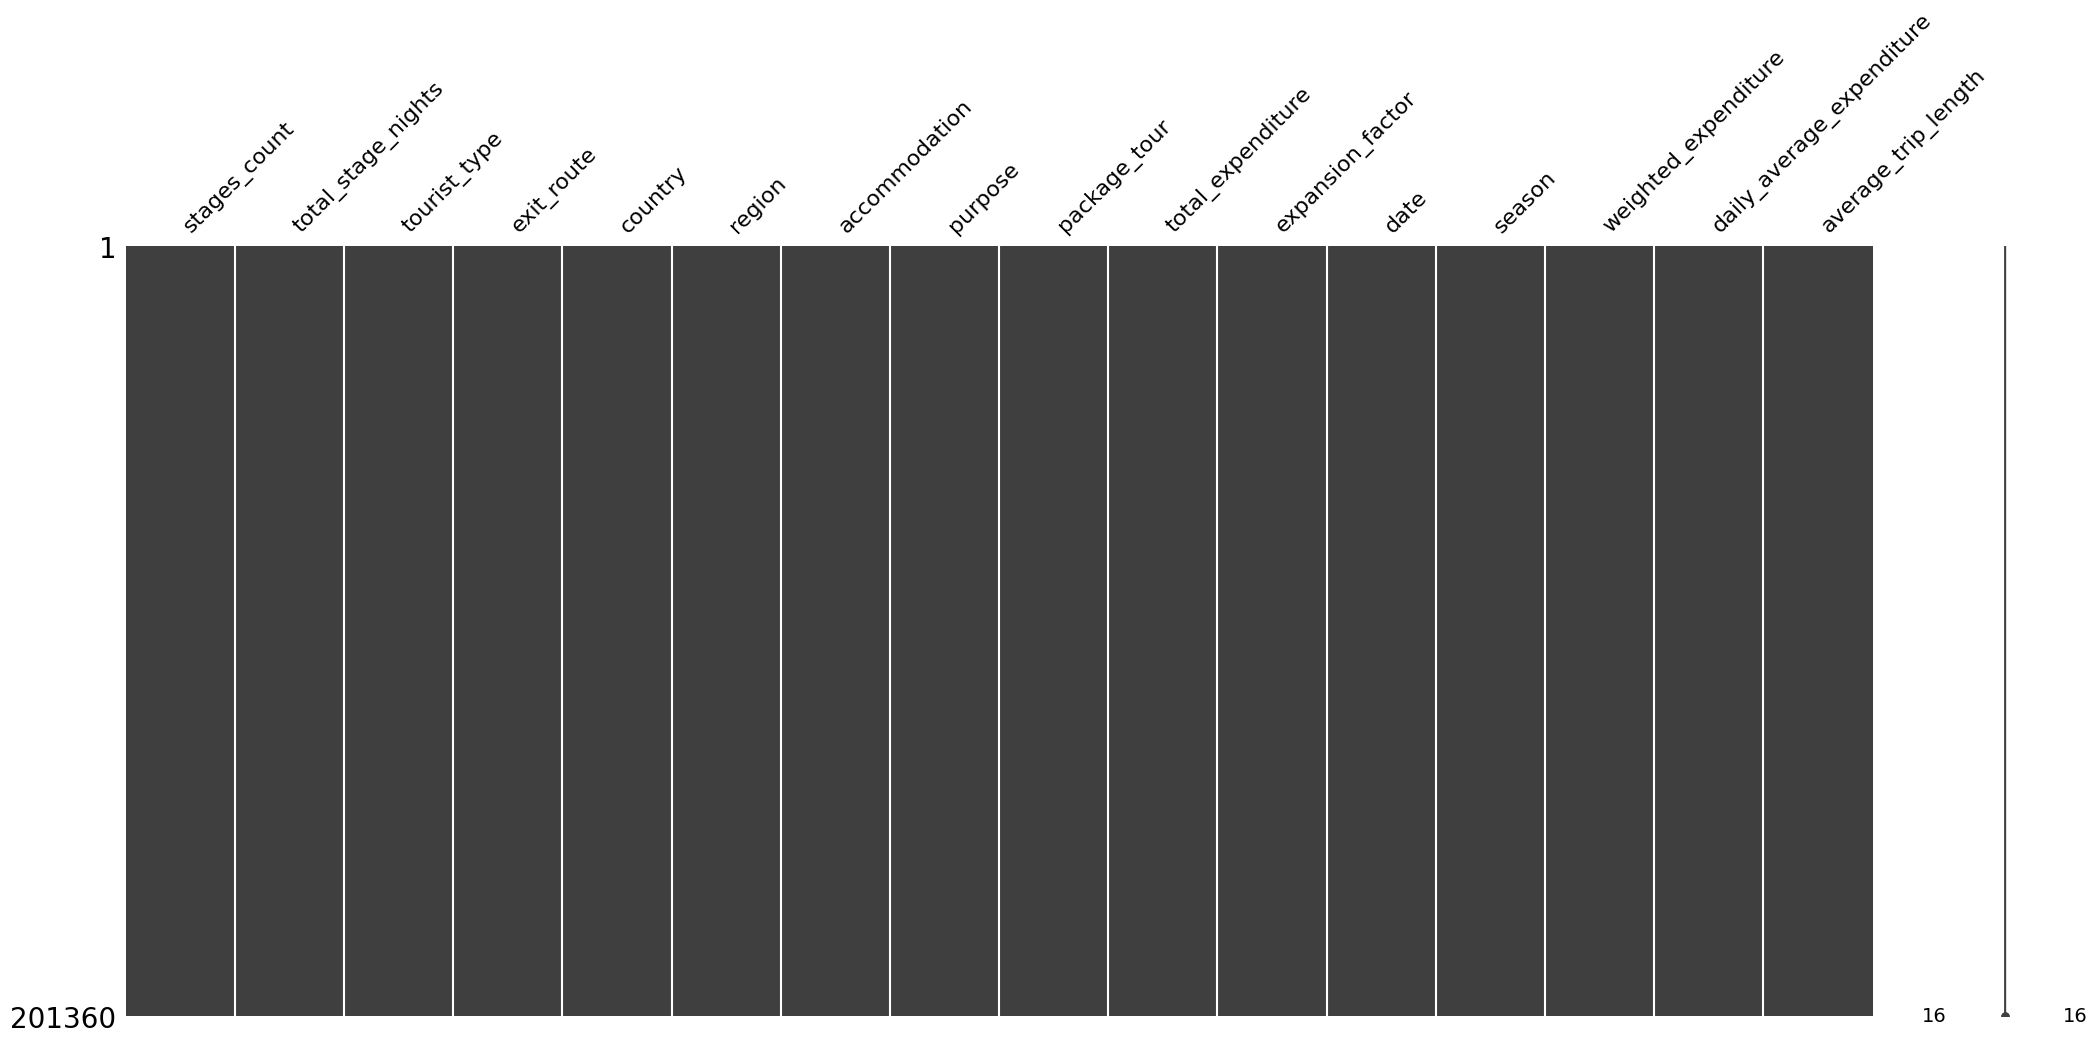

In [272]:
plot_missing_values(df, "matrix")     # Matrix of missing values

## Univariate analysis

### First look at numerical variables

In [273]:
df.describe(include='all')

,stages_count,total_stage_nights,tourist_type,exit_route,country,region,accommodation,purpose,package_tour,total_expenditure,expansion_factor,date,season,weighted_expenditure,daily_average_expenditure,average_trip_length
count,201360.000000,201360.000000,201360,201360,201360,201360,201360,201360,201360,201360.000000,2.013600e+05,201360,201360,2.013600e+05,201360.000000,201360.000000
unique,NaN,NaN,2,4,13,19,3,3,2,NaN,NaN,NaN,4,NaN,NaN,NaN
top,NaN,NaN,Non-resident,Airport,Switzerland,Catalonia,Hotels and similar,Leisure/holidays,No,NaN,NaN,NaN,spring,NaN,NaN,NaN
freq,NaN,NaN,188740,164638,36237,42653,122987,151511,164720,NaN,NaN,NaN,57512,NaN,NaN,NaN
mean,1.198451,8.937942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1452.232207,1.109577e+03,2024-03-12 11:53:52.705601536,NaN,1.462824e+06,237.497803,8.937942
min,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.862770,7.406998e-09,2023-01-01 00:00:00,NaN,2.560074e-05,3.496201,1.000000
25%,1.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,769.712127,2.948826e+02,2023-08-01 00:00:00,NaN,2.922209e+05,134.392702,4.000000
50%,1.000000,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1167.198694,6.770492e+02,2024-03-01 00:00:00,NaN,7.828710e+05,194.566782,6.000000
75%,1.000000,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1685.772886,1.368035e+03,2024-10-01 00:00:00,NaN,1.739232e+06,270.108361,9.000000
max,19.000000,180.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43259.859527,9.955355e+04,2025-06-01 00:00:00,NaN,2.085136e+08,8495.266238,180.000000


In [274]:
numerical_cols = ["total_expenditure", "weighted_expenditure", "daily_average_expenditure", "average_trip_length"]
categorical_cols = ["country", "region", "accommodation", "purpose", "tourist_type", "exit_route", "package_tour", "season"]

date_col = df["date"]

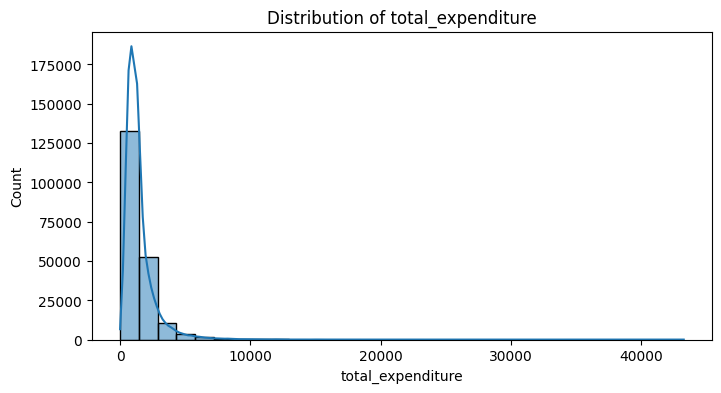

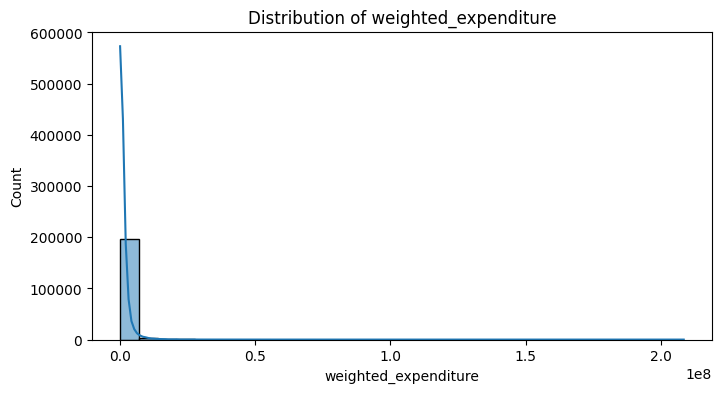

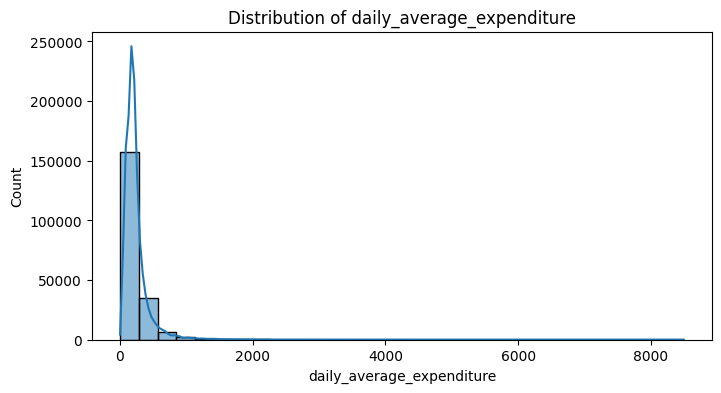

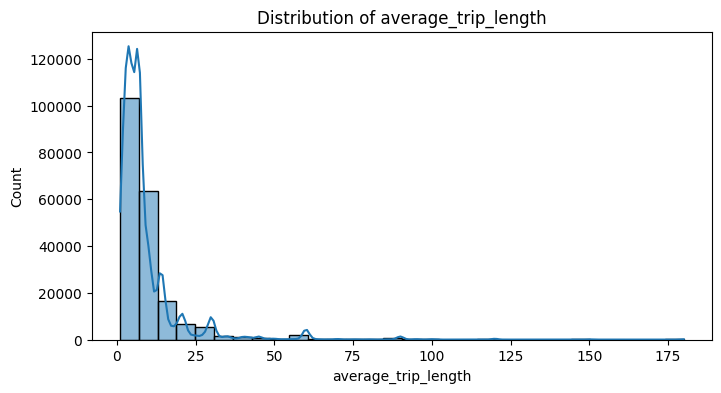

In [275]:
plot_numerical_distributions(df, numerical_cols)

### Outliers

total_expenditure count    201360.000000
mean       1452.232207
std        1223.239118
min           4.862770
50%        1167.198694
95%        3546.853037
99%        6243.275172
max       43259.859527
Name: total_expenditure, dtype: float64


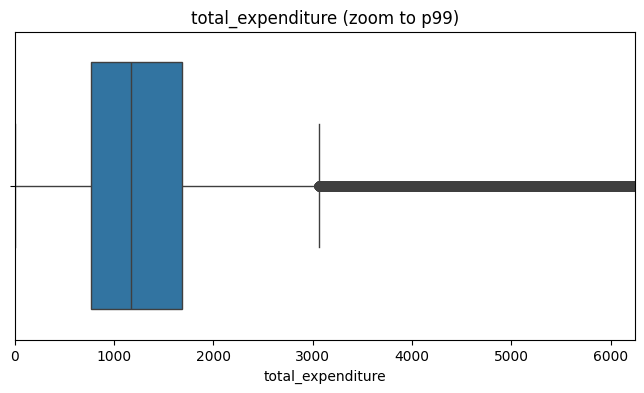

weighted_expenditure count    2.013600e+05
mean     1.462824e+06
std      2.569345e+06
min      2.560074e-05
50%      7.828710e+05
95%      4.763945e+06
99%      1.106737e+07
max      2.085136e+08
Name: weighted_expenditure, dtype: float64


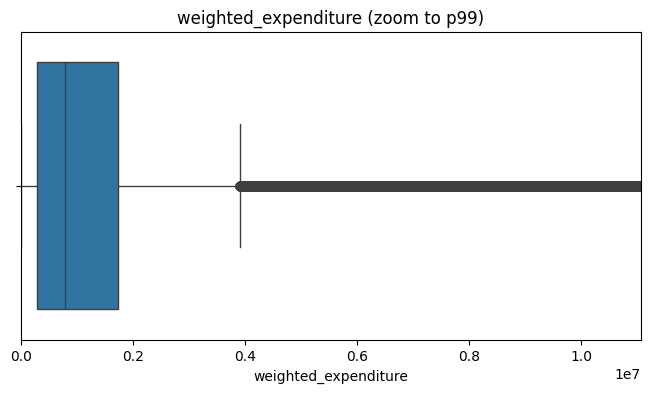

daily_average_expenditure count    201360.000000
mean        237.497803
std         204.398329
min           3.496201
50%         194.566782
95%         554.584749
99%        1048.043658
max        8495.266238
Name: daily_average_expenditure, dtype: float64


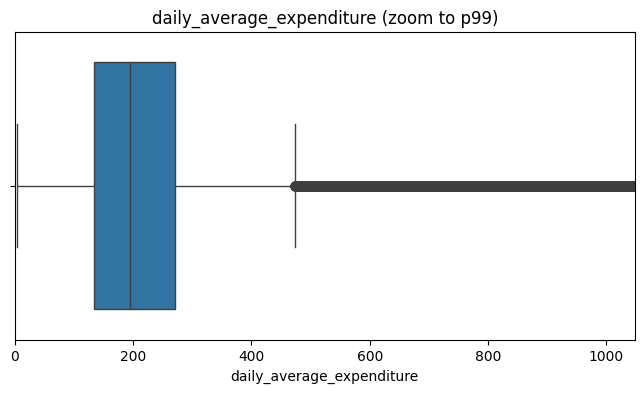

average_trip_length count    201360.000000
mean          8.937942
std          11.557306
min           1.000000
50%           6.000000
95%          30.000000
99%          60.000000
max         180.000000
Name: average_trip_length, dtype: float64


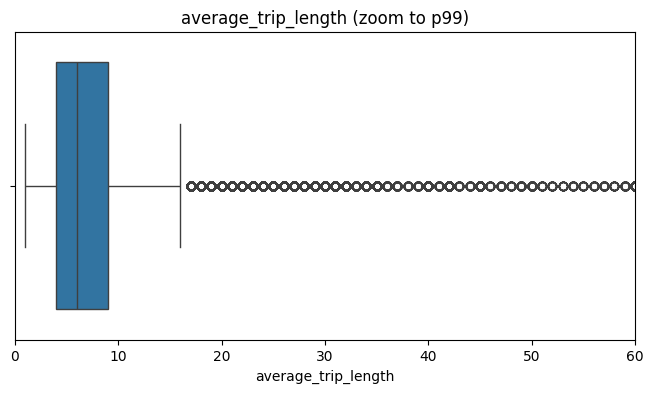

In [276]:
for col in numerical_cols:
    print(col, df[col].describe(percentiles=[0.95, 0.99]))
    
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.xlim(0, df[col].quantile(0.99))  # limit to p99
    plt.title(f"{col} (zoom to p99)")
    plt.show()

Let's inspect the outliers.

In [277]:
for col in numerical_cols:
    threshold = df[col].quantile(0.99)
    outliers = df[df[col] > threshold]
    print(f"\nOutliers in {col} (>{threshold:.2f}): {len(outliers)} cases")
    display(outliers[categorical_cols + [col] + [x for x in numerical_cols if x != col]].head())


Outliers in total_expenditure (>6243.28): 2014 cases


,country,region,accommodation,purpose,tourist_type,exit_route,package_tour,season,total_expenditure,weighted_expenditure,daily_average_expenditure,average_trip_length
83,Rest of the world,Madrid,Hotels and similar,Leisure/holidays,Non-resident in transit,Airport,No,winter,9189.420486,1.216096e+06,382.892520,24.0
263,Germany,Balearic Islands,Non-market,Business,Non-resident,Airport,No,winter,6847.430400,1.808240e+05,97.820434,70.0
274,Netherlands,Murcia,Other market,Other,Non-resident,Airport,No,winter,8657.309840,6.862533e+06,61.837927,140.0
299,Italy,Madrid,Non-market,Other,Non-resident,Port,No,winter,6573.069065,1.598287e+05,109.551151,60.0
300,Italy,Valencian Community,Non-market,Leisure/holidays,Non-resident,Port,No,winter,11881.099293,7.223760e+05,198.018322,60.0



Outliers in weighted_expenditure (>11067365.21): 2014 cases


,country,region,accommodation,purpose,tourist_type,exit_route,package_tour,season,weighted_expenditure,total_expenditure,daily_average_expenditure,average_trip_length
520,Russia,Madrid,Hotels and similar,Leisure/holidays,Non-resident,Airport,Yes,winter,1.708630e+07,2595.903628,432.650605,6.0
635,Switzerland,Canary Islands,Other market,Leisure/holidays,Non-resident,Airport,No,winter,1.333860e+07,2393.664558,170.976040,14.0
675,Netherlands,Canary Islands,Other market,Leisure/holidays,Non-resident,Airport,Yes,winter,2.266275e+07,1503.152033,214.736005,7.0
896,Rest of the world,Catalonia,Other market,Leisure/holidays,Non-resident,Airport,No,winter,2.612933e+07,3133.884003,522.314001,6.0
1056,Switzerland,Canary Islands,Other market,Leisure/holidays,Non-resident,Airport,No,winter,2.676192e+07,1600.844063,228.692009,7.0



Outliers in daily_average_expenditure (>1048.04): 2014 cases


,country,region,accommodation,purpose,tourist_type,exit_route,package_tour,season,daily_average_expenditure,total_expenditure,weighted_expenditure,average_trip_length
56,Rest of the world,Catalonia,Hotels and similar,Leisure/holidays,Non-resident,Airport,No,winter,1241.342136,2482.684272,4.765948e+06,2.0
936,Russia,Madrid,Hotels and similar,Business,Non-resident,Airport,No,winter,1429.031489,1429.031489,1.134596e+06,1.0
1010,Rest of the world,Catalonia,Hotels and similar,Leisure/holidays,Non-resident,Airport,No,winter,3358.043008,3358.043008,4.374556e+06,1.0
1067,Russia,Madrid,Hotels and similar,Other,Non-resident,Airport,No,winter,1375.110887,1375.110887,3.318525e+06,1.0
1079,Rest of the world,Madrid,Non-market,Other,Non-resident,Airport,No,winter,1123.788903,2247.577805,7.310548e+05,2.0



Outliers in average_trip_length (>60.00): 1752 cases


,country,region,accommodation,purpose,tourist_type,exit_route,package_tour,season,average_trip_length,total_expenditure,weighted_expenditure,daily_average_expenditure
245,Switzerland,Andalusia,Other market,Leisure/holidays,Non-resident,Road,No,winter,61.0,4008.224867,2.506483e+06,65.708604
263,Germany,Balearic Islands,Non-market,Business,Non-resident,Airport,No,winter,70.0,6847.430400,1.808240e+05,97.820434
274,Netherlands,Murcia,Other market,Other,Non-resident,Airport,No,winter,140.0,8657.309840,6.862533e+06,61.837927
299,Italy,Madrid,Non-market,Other,Non-resident,Port,No,winter,60.0,6573.069065,1.598287e+05,109.551151
405,Switzerland,Navarre,Other market,Leisure/holidays,Non-resident,Road,No,winter,61.0,6132.959163,3.964900e+05,100.540314


This is unexpected, there is the same number of outliers in total_expenditure, weighted_expenditure and daily_average_expenditure. But the outliers are mostly different; it could be expected that high total expenditure should be correlated to high daily expenditure...

In [278]:
"""
from scipy.stats.mstats import winsorize

# ==========================
# 1. Winsorization p0–p99
# ==========================

def winsorize_series(s: pd.Series, limits=(0.0, 0.01)):
    \"""
    Winsorize a pandas Series using scipy.stats.mstats.winsorize.
    By default clips the upper 1%.
    \"""
    return pd.Series(winsorize(s, limits=limits), index=s.index)

# Create winsorized copy
df_winsor = df.copy()
for col in numerical_cols:
    df_winsor[f"{col}_win"] = winsorize_series(df[col], limits=(0.0, 0.01))
"""

# ==========================
# 2. Subset of “extreme tourists”
# ==========================

outliers_dict = {}
for col in numerical_cols:
    upper = df[col].quantile(0.99)
    
    # Save subset of outliers for this col
    outliers_col = df[(df[col] > upper)]
    outliers_dict[col] = outliers_col


# ==========================
# 3. Global subset of outliers
# ==========================

# Union of all outliers in any variable
outliers_global = pd.concat(outliers_dict.values()).drop_duplicates()
print(f"\nTotal extreme tourists (any variable): {len(outliers_global)} cases")

# Show first cases
display(outliers_global[categorical_cols + numerical_cols].head())



Total extreme tourists (any variable): 6603 cases


,country,region,accommodation,purpose,tourist_type,exit_route,package_tour,season,total_expenditure,weighted_expenditure,daily_average_expenditure,average_trip_length
83,Rest of the world,Madrid,Hotels and similar,Leisure/holidays,Non-resident in transit,Airport,No,winter,9189.420486,1.216096e+06,382.892520,24.0
263,Germany,Balearic Islands,Non-market,Business,Non-resident,Airport,No,winter,6847.430400,1.808240e+05,97.820434,70.0
274,Netherlands,Murcia,Other market,Other,Non-resident,Airport,No,winter,8657.309840,6.862533e+06,61.837927,140.0
299,Italy,Madrid,Non-market,Other,Non-resident,Port,No,winter,6573.069065,1.598287e+05,109.551151,60.0
300,Italy,Valencian Community,Non-market,Leisure/holidays,Non-resident,Port,No,winter,11881.099293,7.223760e+05,198.018322,60.0


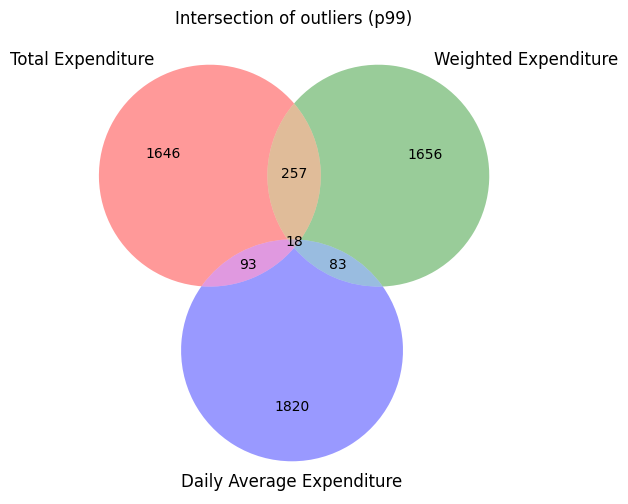

In [279]:
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt

# Sets of outlier indices
out_total_expenditure = set(outliers_dict["total_expenditure"].index)
out_weighted_expenditure = set(outliers_dict["weighted_expenditure"].index)
out_daily_avg_expenditure = set(outliers_dict["daily_average_expenditure"].index)

plt.figure(figsize=(8,6))
venn3([out_total_expenditure, out_weighted_expenditure, out_daily_avg_expenditure],
      set_labels=('Total Expenditure', 'Weighted Expenditure', 'Daily Average Expenditure'))
plt.title("Intersection of outliers (p99)")
plt.show()

/home/gregorio/Escritorio/Master/TFM/TFM/TFM_venv/lib/python3.11/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/gregorio/Escritorio/Master/TFM/TFM/TFM_venv/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the or

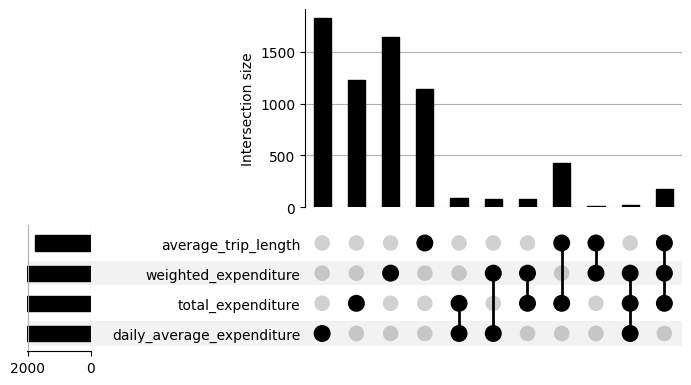

In [280]:
from upsetplot import UpSet, from_memberships

memberships = []
for i in df.index:
    flags = []
    for col in numerical_cols:
        if i in outliers_dict[col].index:
            flags.append(col)
    if flags:
        memberships.append(flags)

data = from_memberships(memberships)
UpSet(data, subset_size='count').plot()
plt.show()

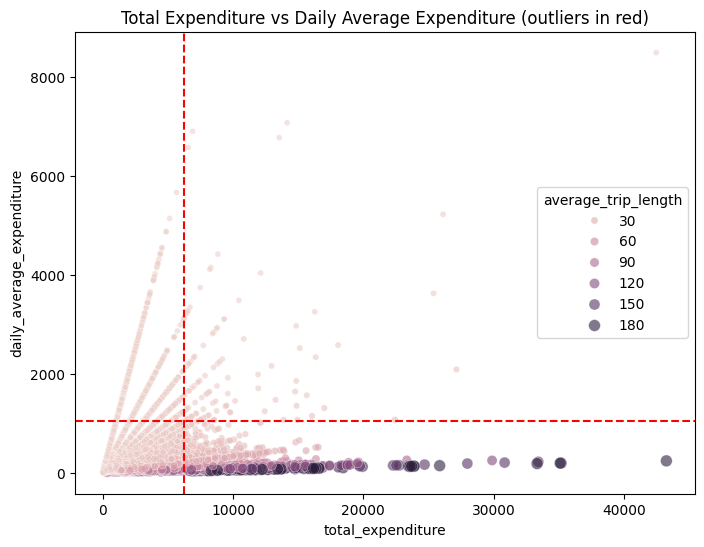

In [281]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="total_expenditure", y="daily_average_expenditure",
    hue="average_trip_length", size="average_trip_length",
    alpha=0.6, legend="brief"
)
plt.axvline(df["total_expenditure"].quantile(0.99), color="r", ls="--")
plt.axhline(df["daily_average_expenditure"].quantile(0.99), color="r", ls="--")
plt.title("Total Expenditure vs Daily Average Expenditure (outliers in red)")
plt.show()


### Numerical variables

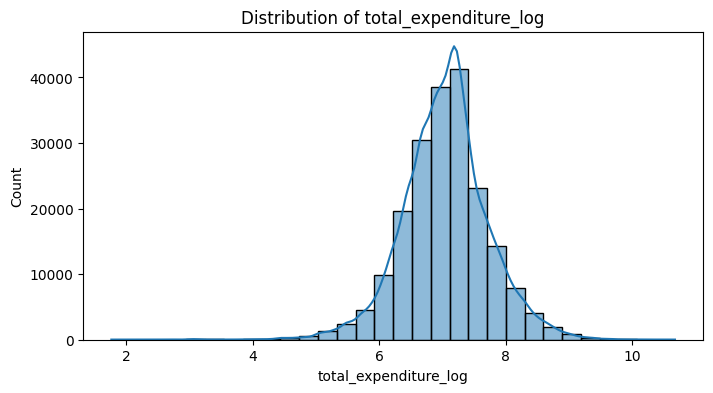

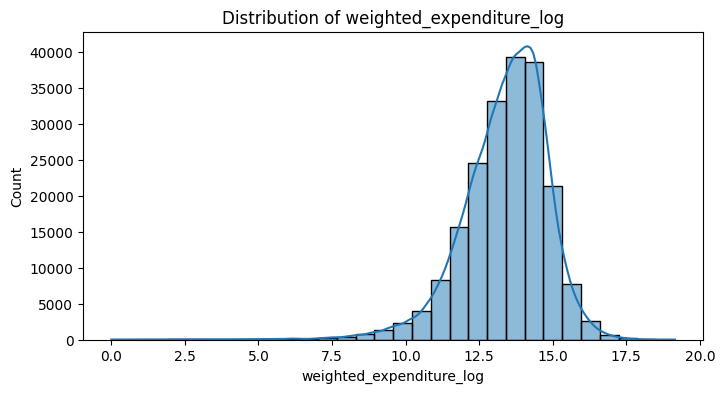

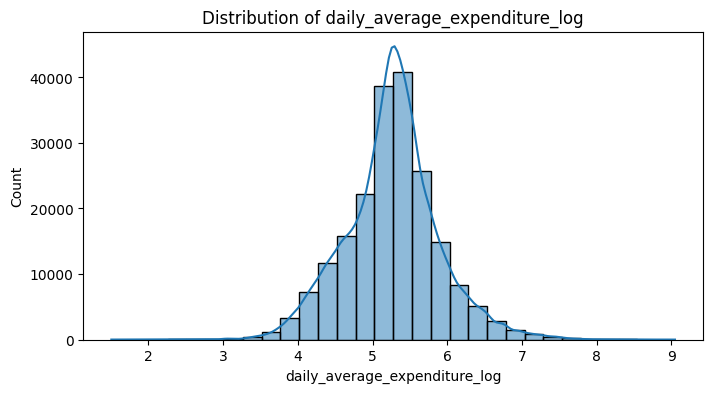

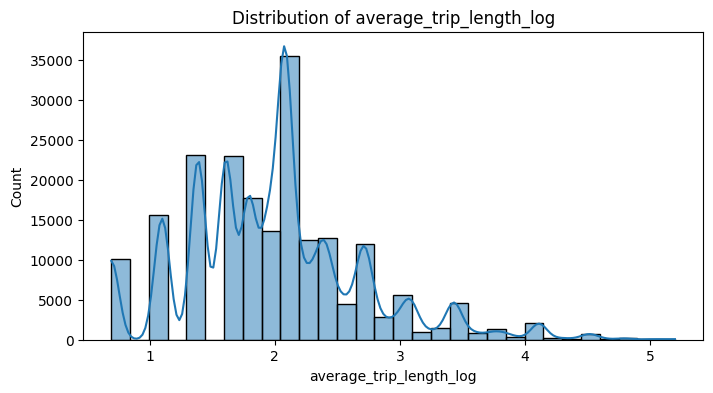

In [282]:
import numpy as np

# Create new log-transformed columns (adding +1 to avoid log(0))
df_log = df.copy()
for col in numerical_cols:
    df_log[f"{col}_log"] = np.log1p(df_log[col])  # log(1+x)

plot_numerical_distributions(df_log, [f"{col}_log" for col in numerical_cols])

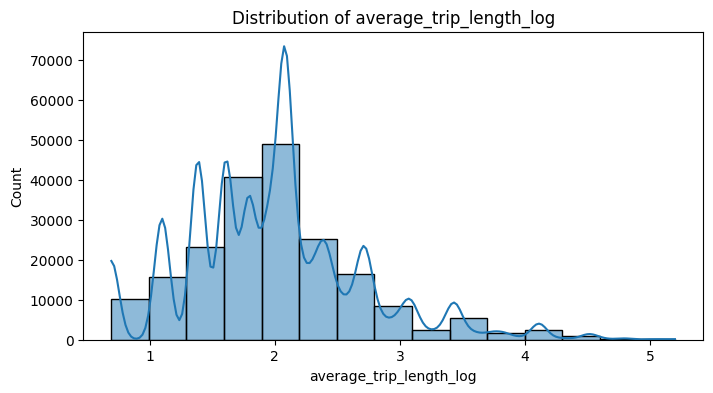

In [283]:
plot_numerical_distributions(df_log, [f"average_trip_length_log"], bins=15)

/home/gregorio/Escritorio/Master/TFM/TFM/TFM_venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


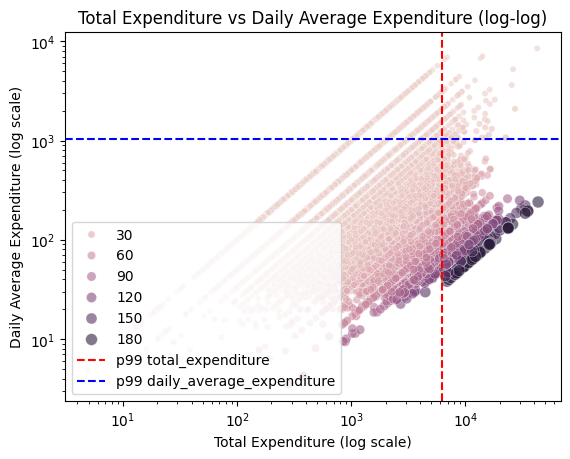

In [284]:
# Scatter with log-log axes
sns.scatterplot(
    data=df,
    x="total_expenditure", y="daily_average_expenditure",
    hue="average_trip_length", size="average_trip_length",
    alpha=0.6, legend="brief"
)

# Logarithmic scale on both axes
plt.xscale("log")
plt.yscale("log")

# Cut lines at the 99th percentile (outliers)
plt.axvline(df["total_expenditure"].quantile(0.99), color="r", ls="--", label="p99 total_expenditure")
plt.axhline(df["daily_average_expenditure"].quantile(0.99), color="b", ls="--", label="p99 daily_average_expenditure")

plt.title("Total Expenditure vs Daily Average Expenditure (log-log)")
plt.xlabel("Total Expenditure (log scale)")
plt.ylabel("Daily Average Expenditure (log scale)")
plt.legend()
plt.show()

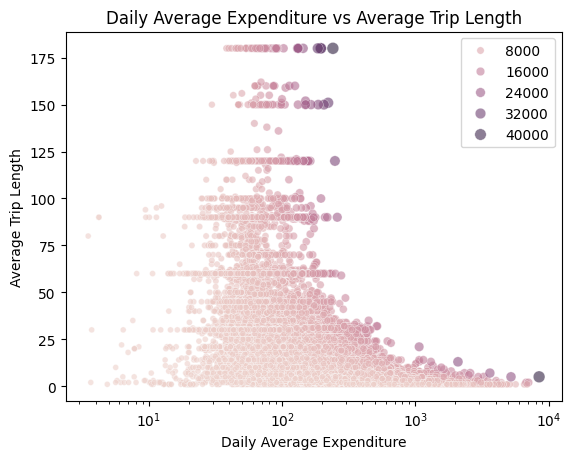

In [285]:
# Scatter with log-x axis
sns.scatterplot(
    data=df,
    x="daily_average_expenditure", y="average_trip_length",
    hue="total_expenditure", size="total_expenditure",
    alpha=0.6, legend="brief"
)

plt.xscale("log")

plt.title("Daily Average Expenditure vs Average Trip Length")
plt.xlabel("Daily Average Expenditure")
plt.ylabel("Average Trip Length")
plt.legend()
plt.show()

### Categorical variables

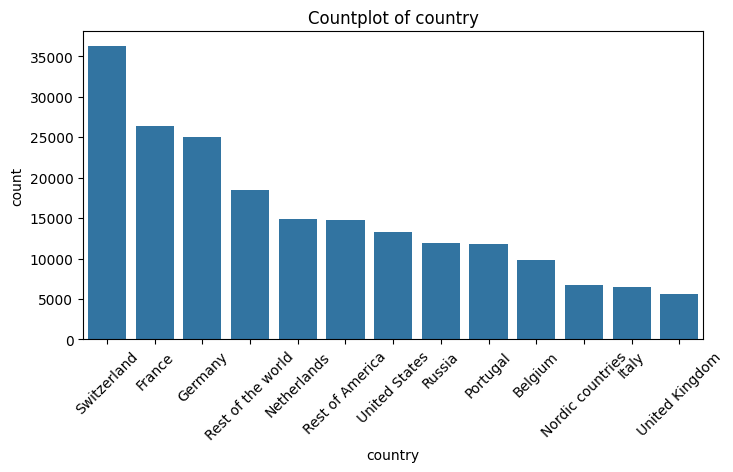

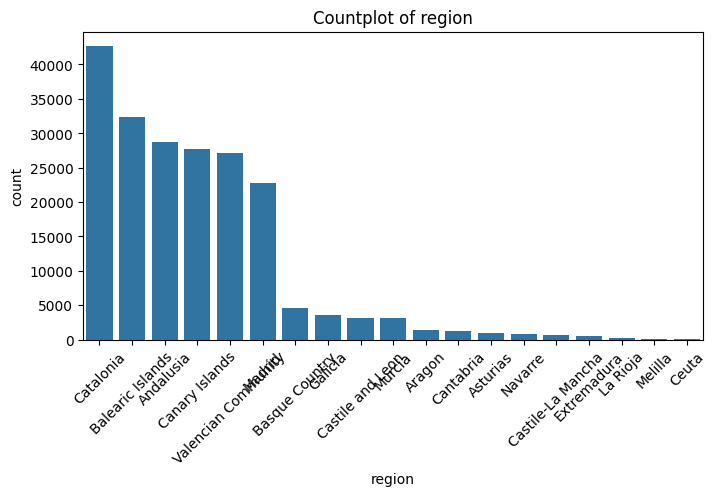

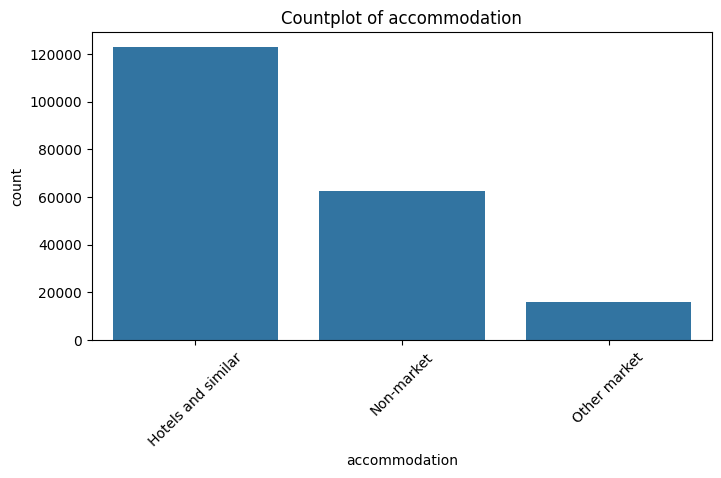

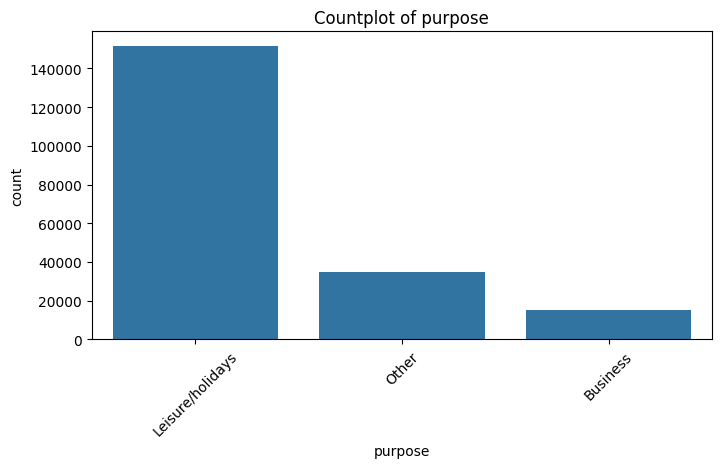

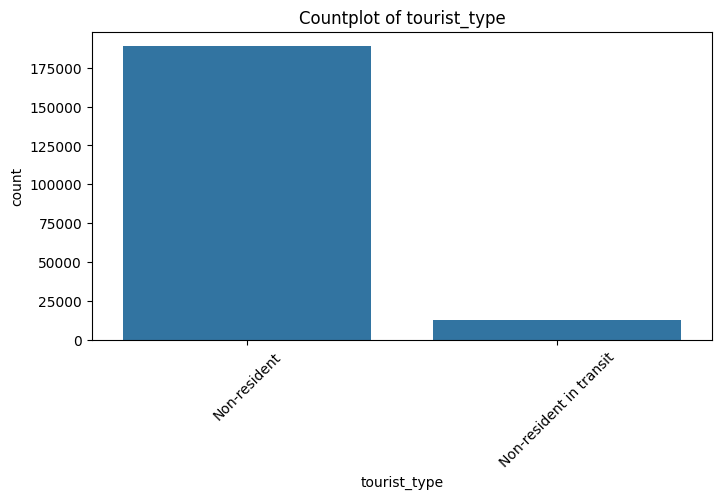

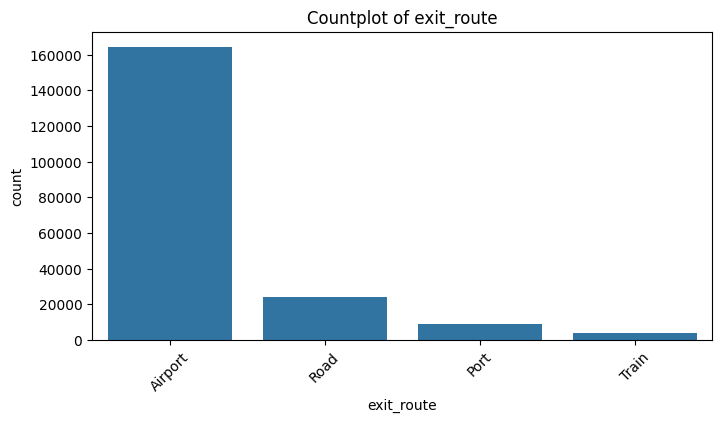

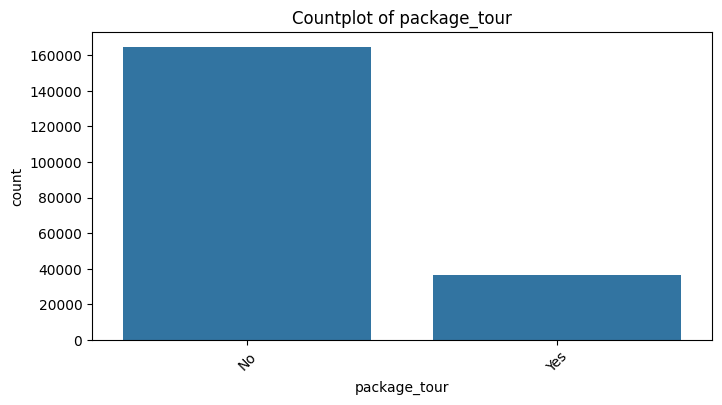

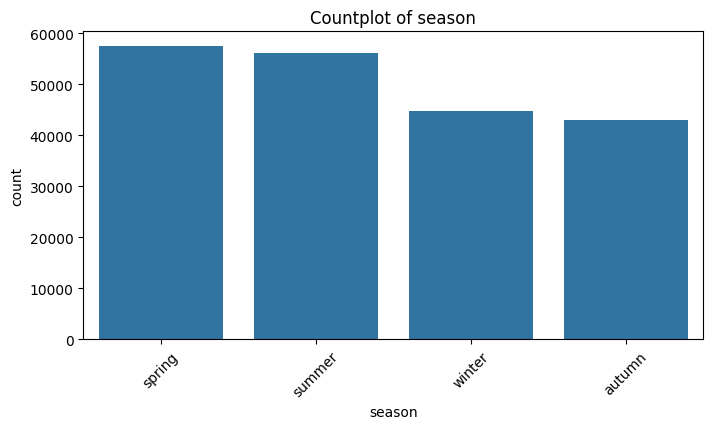

In [286]:
plot_categorical_counts(df, categorical_cols)

In [287]:
df_log

,stages_count,total_stage_nights,tourist_type,exit_route,country,region,accommodation,purpose,package_tour,total_expenditure,expansion_factor,date,season,weighted_expenditure,daily_average_expenditure,average_trip_length,total_expenditure_log,weighted_expenditure_log,daily_average_expenditure_log,average_trip_length_log
0,1,14,Non-resident,Airport,Rest of America,Valencian Community,Non-market,Leisure/holidays,No,1810.465932,375.936311,2023-12-01,winter,680619.883798,129.318995,14.0,7.501892,13.430761,4.869985,2.708050
1,2,16,Non-resident,Airport,Rest of America,Valencian Community,Non-market,Leisure/holidays,No,2035.596336,324.888905,2023-12-01,winter,661342.665150,127.224771,16.0,7.619035,13.402029,4.853785,2.833213
2,1,9,Non-resident,Airport,Rest of America,Madrid,Hotels and similar,Leisure/holidays,No,2460.725851,115.019771,2023-12-01,winter,283032.122790,273.413983,9.0,7.808618,12.553319,5.614638,2.302585
3,3,27,Non-resident,Airport,Rest of America,Valencian Community,Non-market,Leisure/holidays,No,3010.324516,86.451770,2023-12-01,winter,260247.882432,111.493501,27.0,8.010135,12.469394,4.722895,3.332205
4,1,14,Non-resident,Airport,Rest of America,Canary Islands,Non-market,Other,No,1747.853281,236.780128,2023-12-01,winter,413856.923030,124.846663,14.0,7.466716,12.933278,4.835064,2.708050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201355,1,4,Non-resident,Train,United Kingdom,Galicia,Other market,Other,No,502.608651,68.834250,2023-06-01,summer,34596.689604,125.652163,4.0,6.221799,10.451542,4.841444,1.609438
201356,1,10,Non-resident,Train,United Kingdom,Galicia,Non-market,Other,No,629.494471,10.949028,2023-06-01,summer,6892.352781,62.949447,10.0,6.446504,8.838313,4.158093,2.397895
201357,1,5,Non-resident,Train,Rest of the world,Galicia,Hotels and similar,Leisure/holidays,No,2541.791963,279.265621,2023-06-01,summer,709835.111577,508.358393,5.0,7.841018,13.472789,6.233152,1.791759
201358,1,6,Non-resident,Train,United Kingdom,Galicia,Other market,Other,No,535.842728,45.889500,2023-06-01,summer,24589.554940,89.307121,6.0,6.285705,10.110118,4.503216,1.945910


In [288]:
# Copy df to avoid overwriting original
df_clean = df_log.copy()

# 1. Country -> Top 10 + aggregated categories
top_countries = df_clean["country"].value_counts().nlargest(10).index.tolist()
aggregated = ["Rest of the world", "Rest of America", "Nordic countries"]
df_clean["country_clean"] = df_clean["country"].where(df_clean["country"].isin(top_countries + aggregated), "Other")

# 2. Region -> 6 main + Other
top_regions = ["Catalonia", "Balearic Islands", "Andalusia", 
            "Canary Islands", "Valencian Community", "Madrid"]
df_clean["region_clean"] = df_clean["region"].where(df_clean["region"].isin(top_regions), "Other")

# The rest remain the same
df_clean["accommodation_clean"] = df_clean["accommodation"]
df_clean["purpose_clean"] = df_clean["purpose"]
df_clean["tourist_type_clean"] = df_clean["tourist_type"]
df_clean["exit_route_clean"] = df_clean["exit_route"]
df_clean["package_tour_clean"] = df_clean["package_tour"]
df_clean["season_clean"] = df_clean["season"]

# Quick check
for col in ["country_clean", "region_clean", "accommodation_clean", "purpose_clean", 
            "tourist_type_clean", "exit_route_clean", "package_tour_clean", "season_clean"]:
    print(df_clean[col].value_counts(normalize=True).round(3))
    print()

country_clean
Switzerland          0.180
France               0.131
Germany              0.124
Rest of the world    0.092
Netherlands          0.074
Rest of America      0.073
United States        0.066
Other                0.060
Russia               0.059
Portugal             0.059
Belgium              0.049
Nordic countries     0.033
Name: proportion, dtype: float64

region_clean
Catalonia              0.212
Balearic Islands       0.160
Andalusia              0.143
Canary Islands         0.138
Valencian Community    0.134
Madrid                 0.113
Other                  0.100
Name: proportion, dtype: float64

accommodation_clean
Hotels and similar    0.611
Non-market            0.310
Other market          0.079
Name: proportion, dtype: float64

purpose_clean
Leisure/holidays    0.752
Other               0.173
Business            0.075
Name: proportion, dtype: float64

tourist_type_clean
Non-resident               0.937
Non-resident in transit    0.063
Name: proportion, dtype: floa

## Bivariate analysis

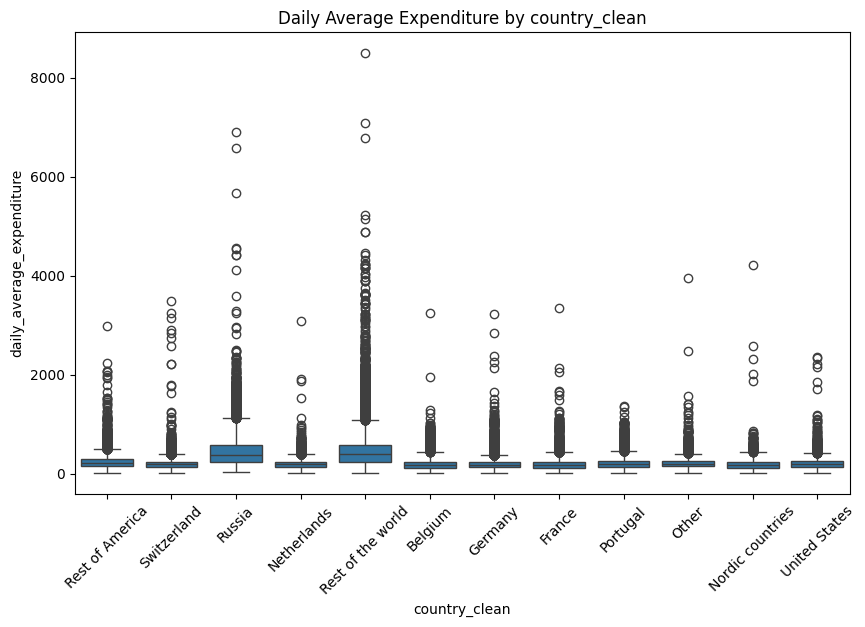

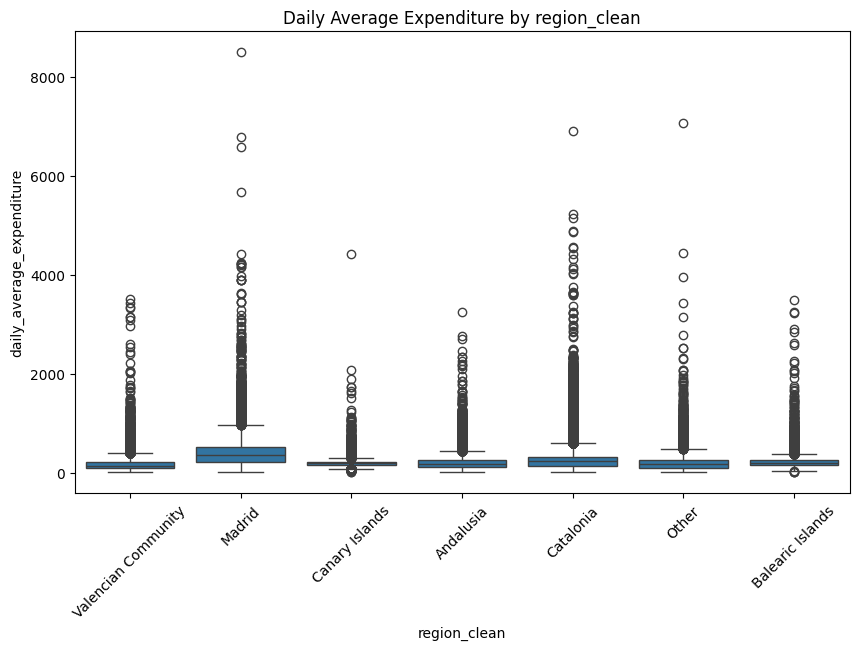

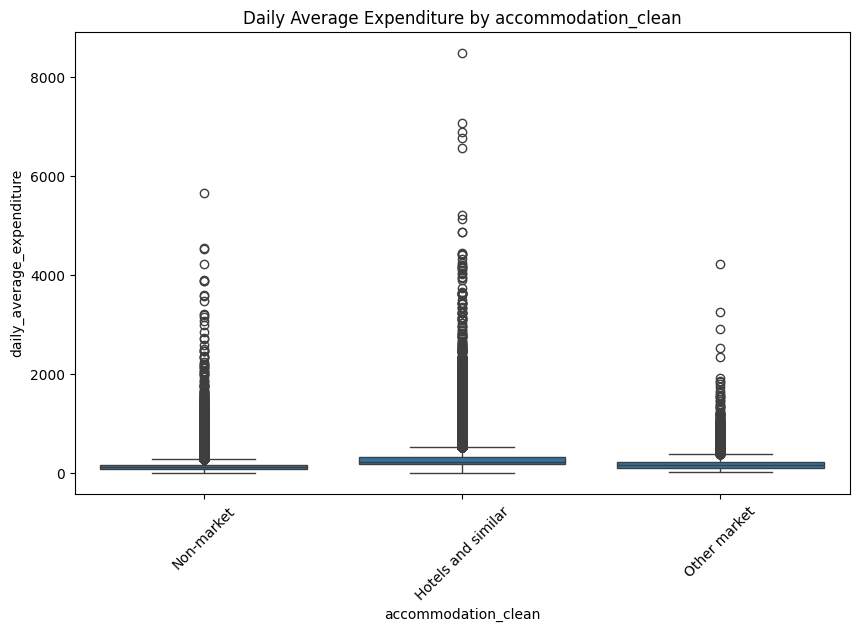

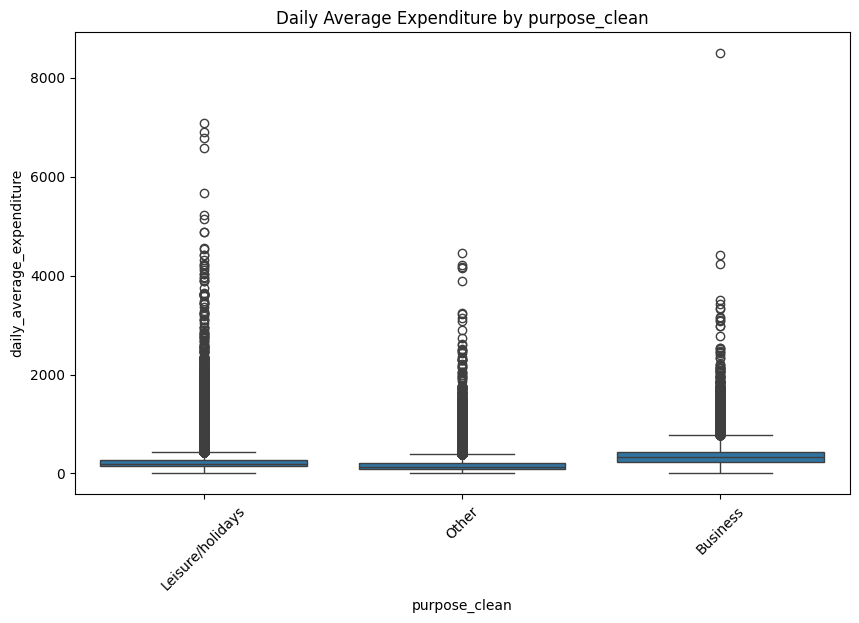

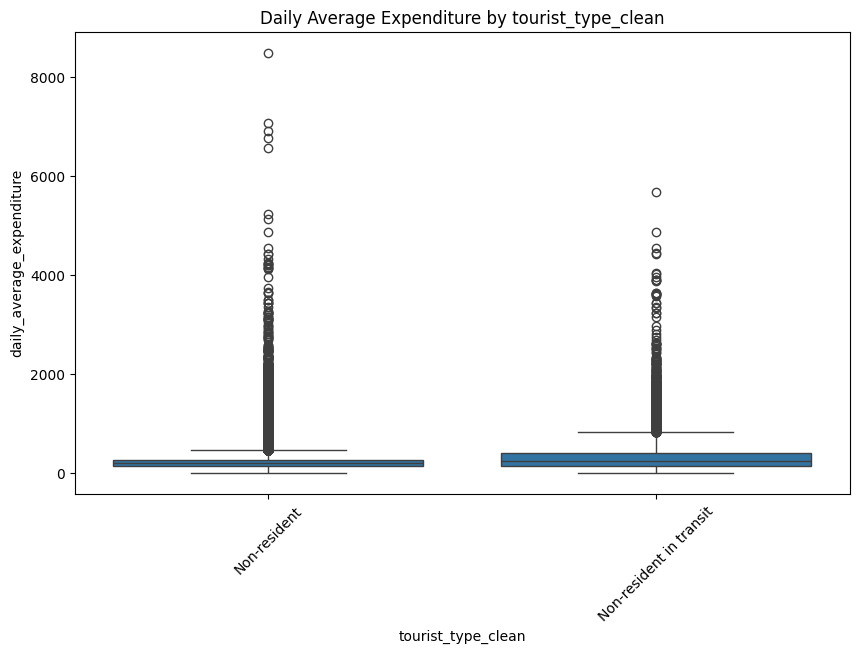

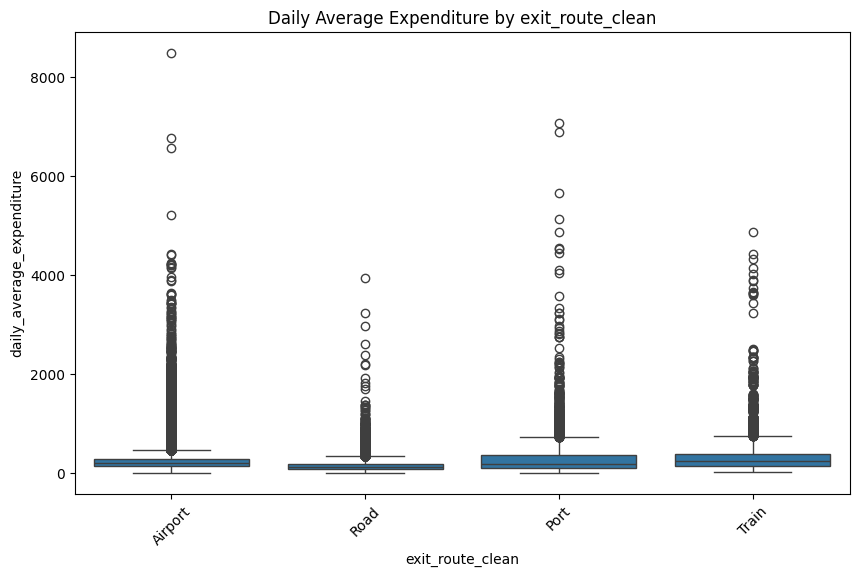

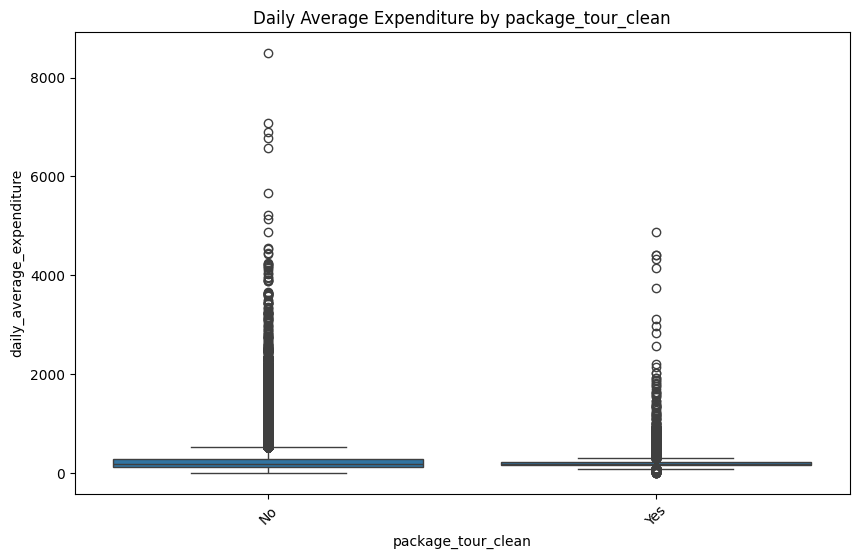

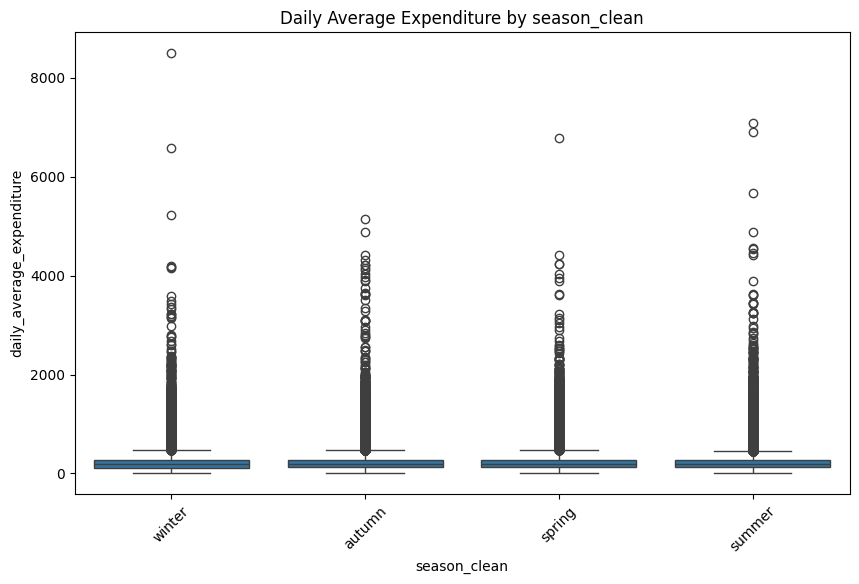

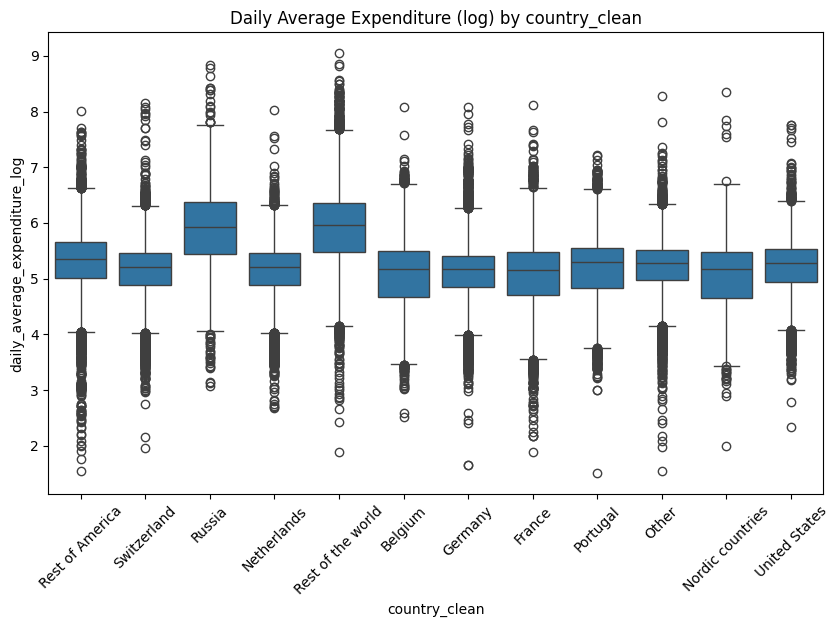

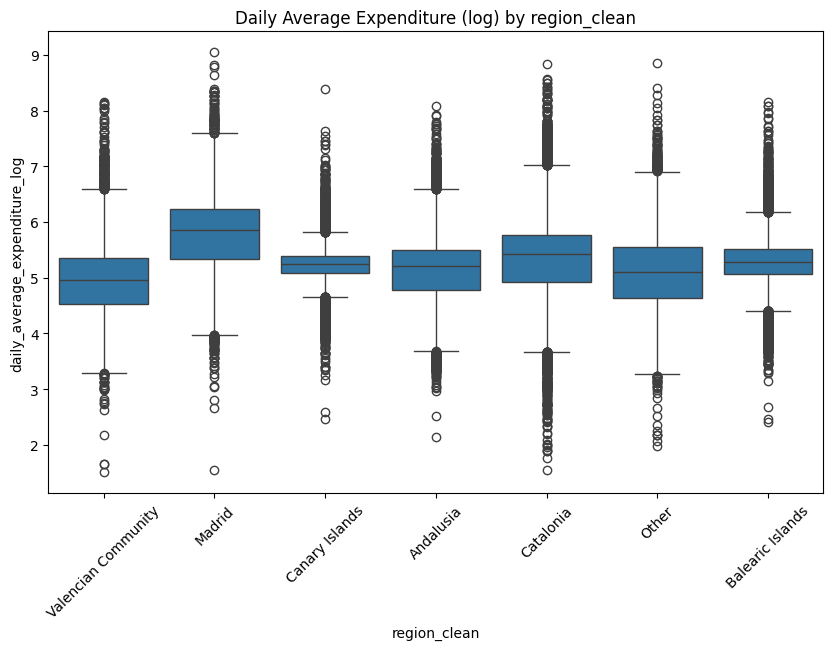

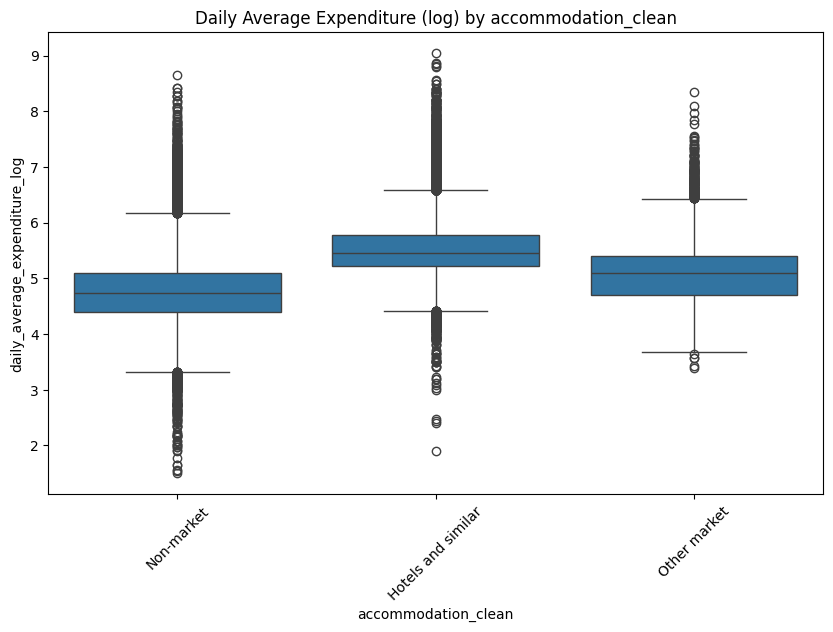

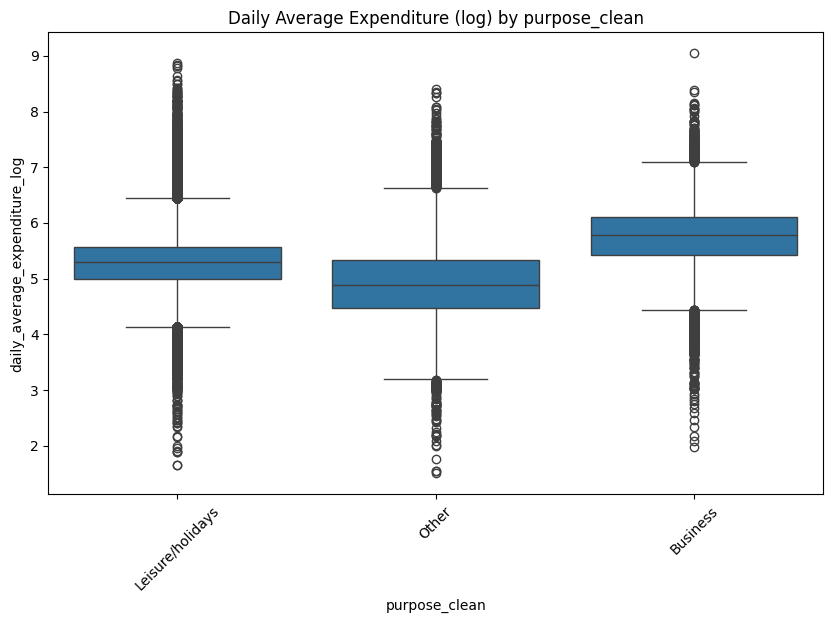

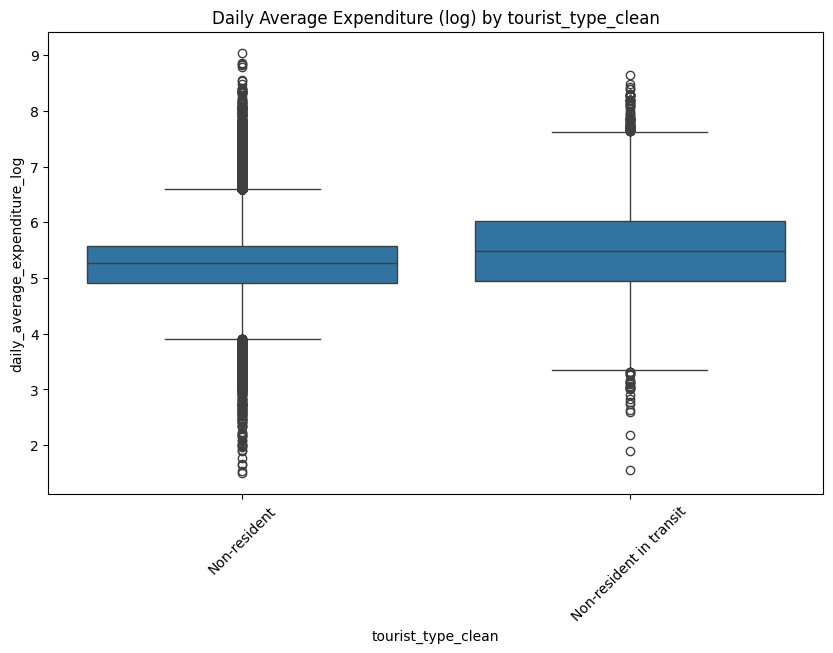

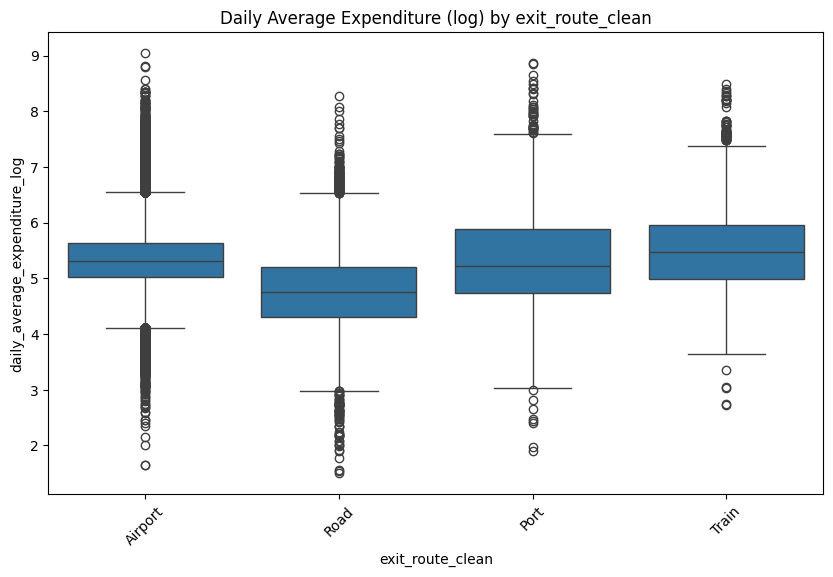

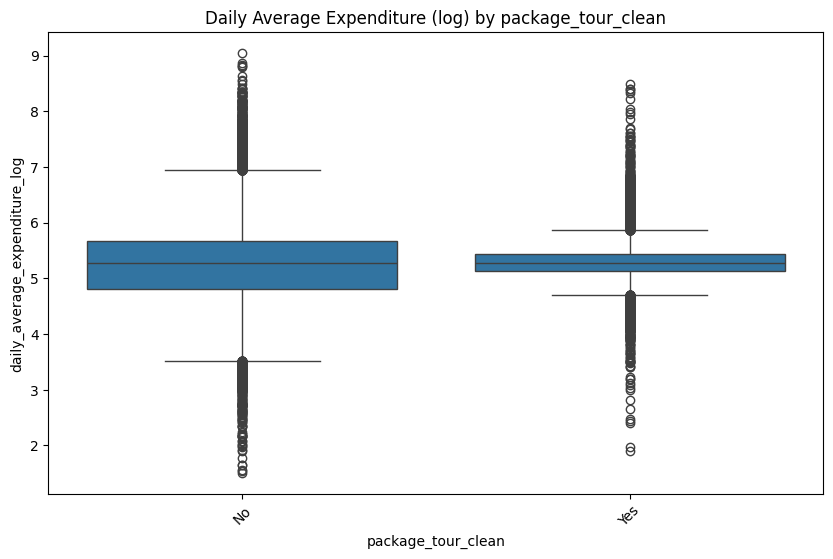

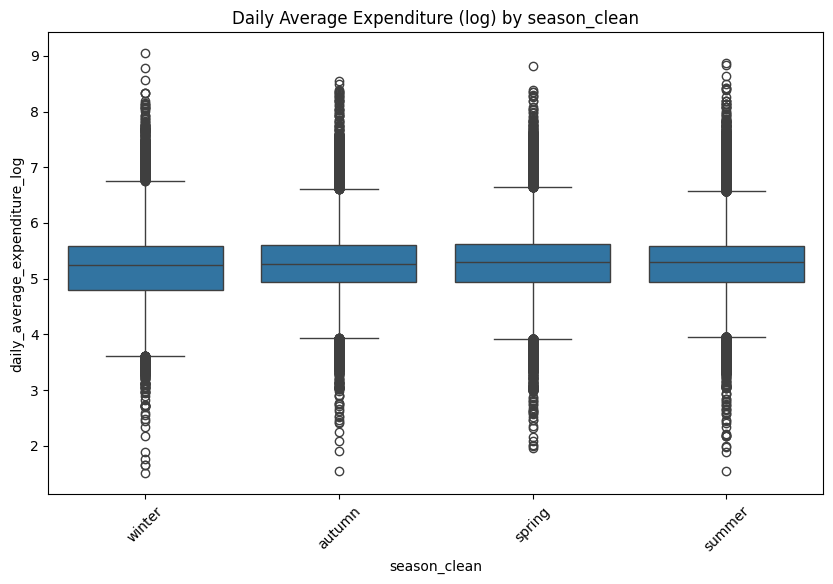

In [289]:
import seaborn as sns
import matplotlib.pyplot as plt

cat_vars = ["country_clean", "region_clean", "accommodation_clean", "purpose_clean",
            "tourist_type_clean", "exit_route_clean", "package_tour_clean", "season_clean"]

for col in cat_vars:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_clean, x=col, y="daily_average_expenditure")
    plt.xticks(rotation=45)
    plt.title(f"Daily Average Expenditure by {col}")
    plt.show()

for col in cat_vars:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_clean, x=col, y="daily_average_expenditure_log")
    plt.xticks(rotation=45)
    plt.title(f"Daily Average Expenditure (log) by {col}")
    plt.show()

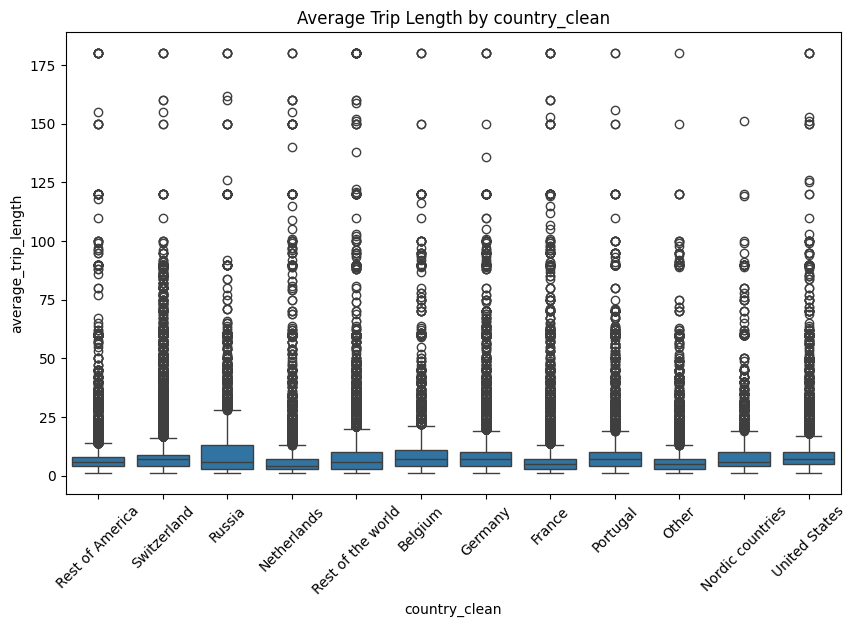

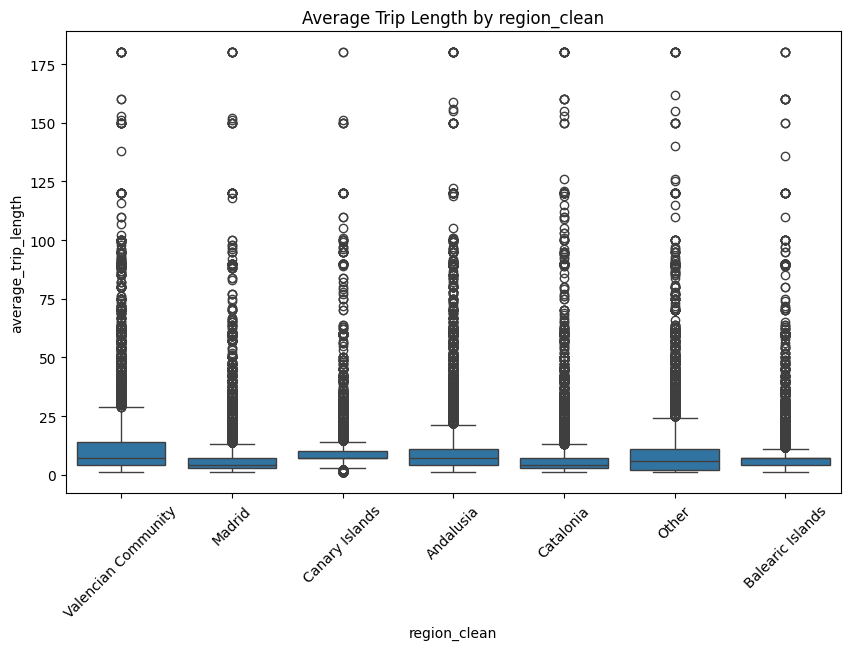

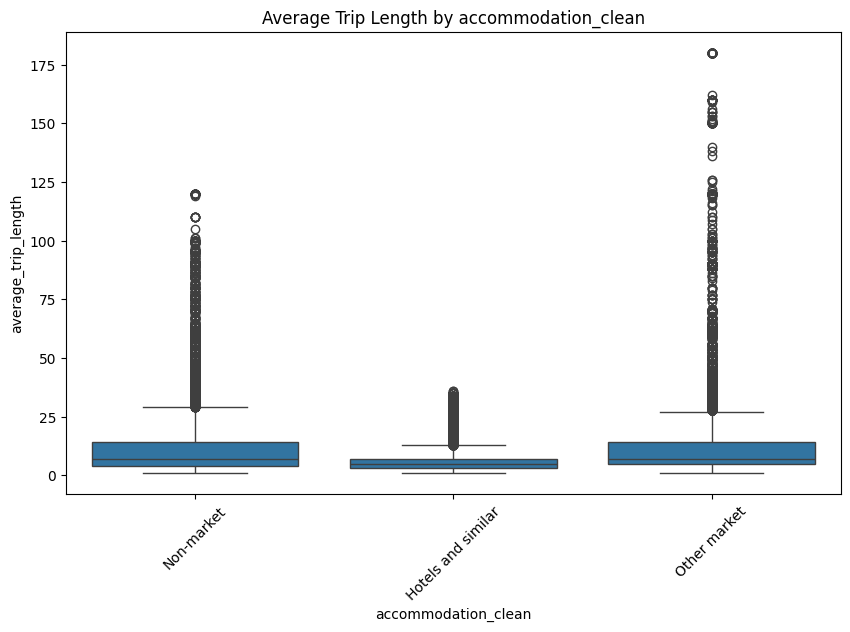

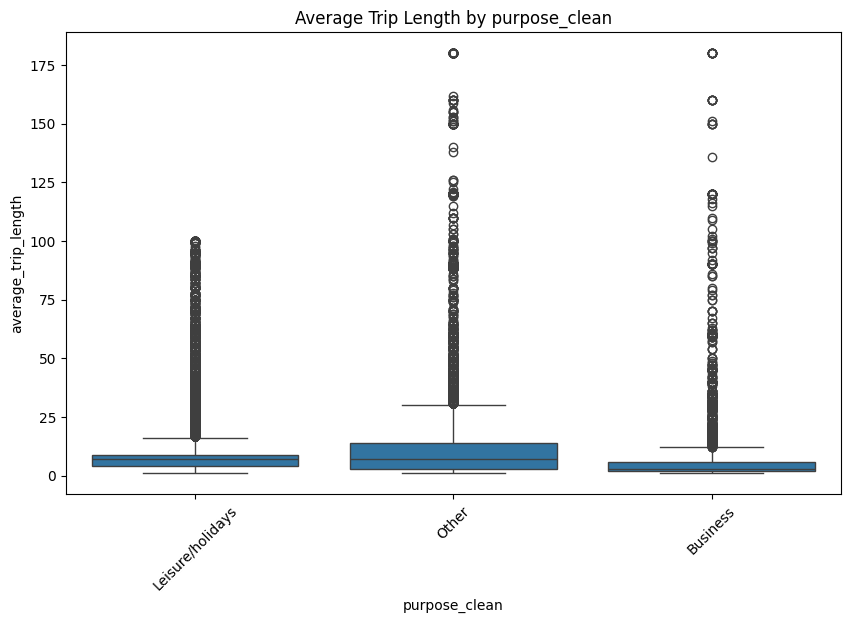

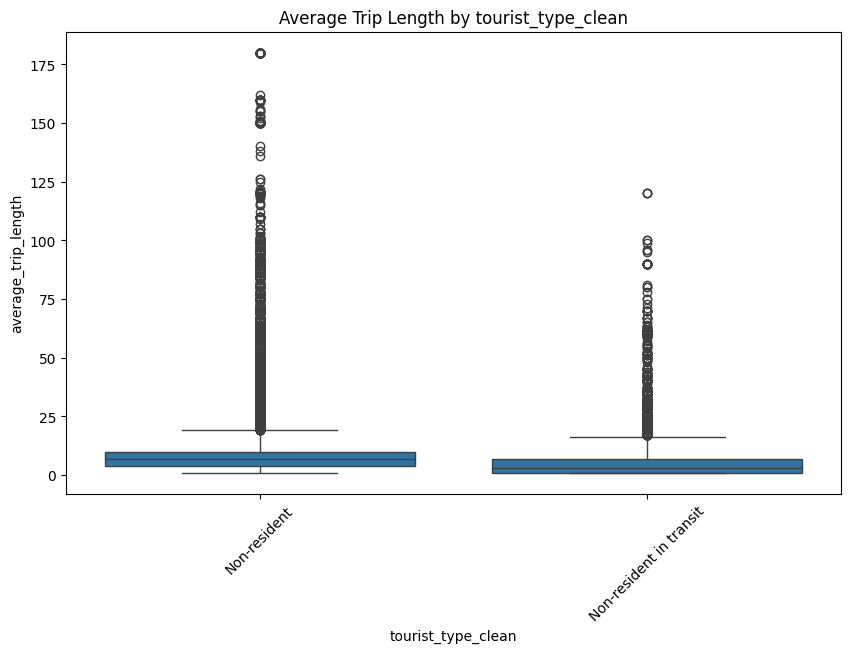

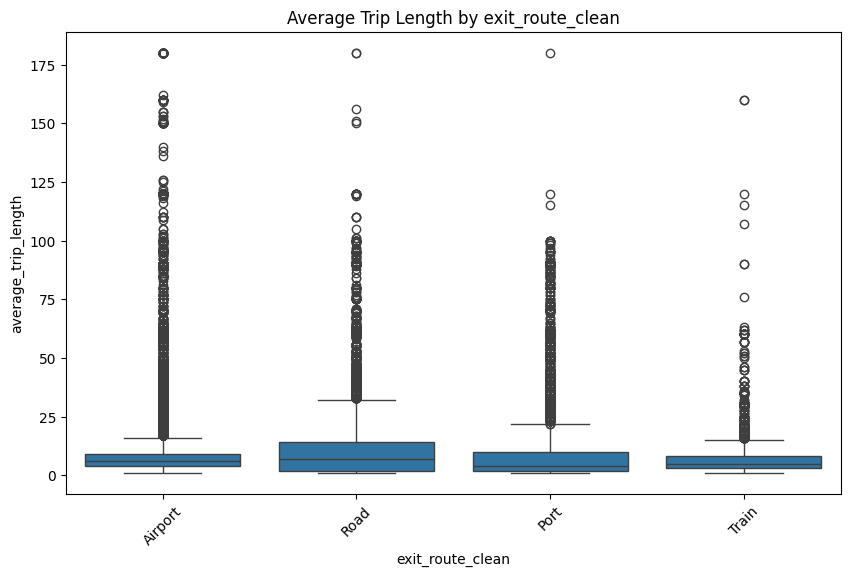

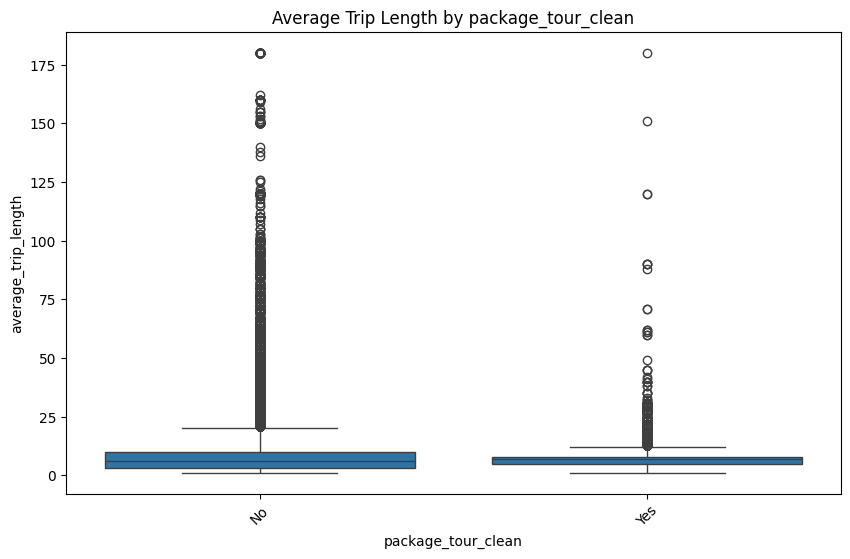

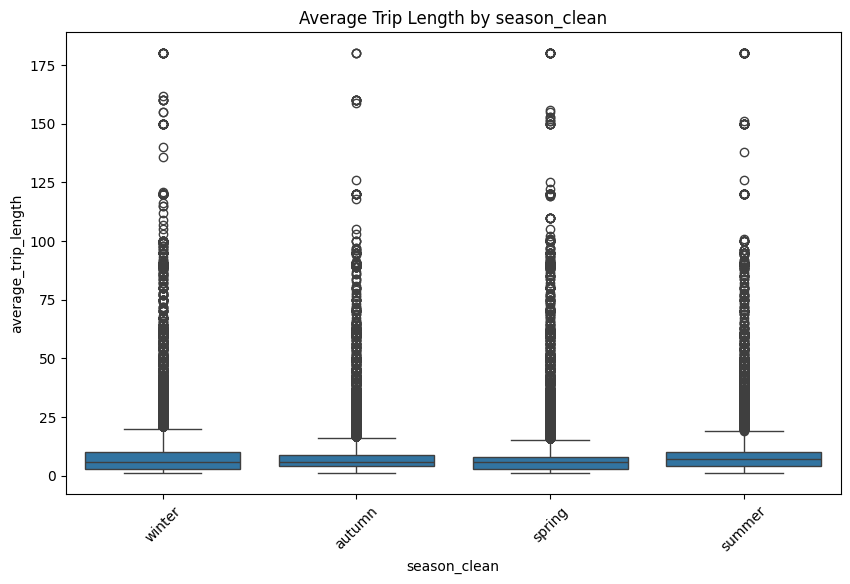

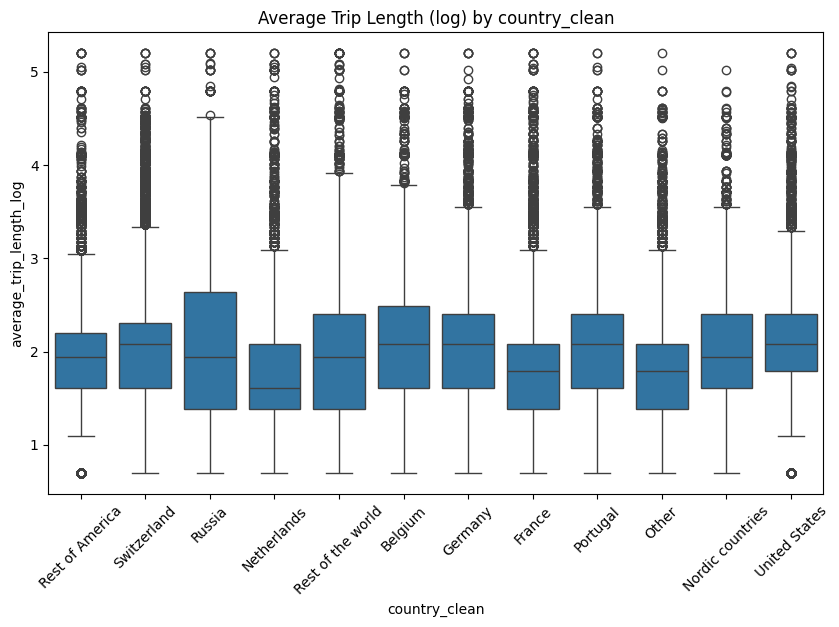

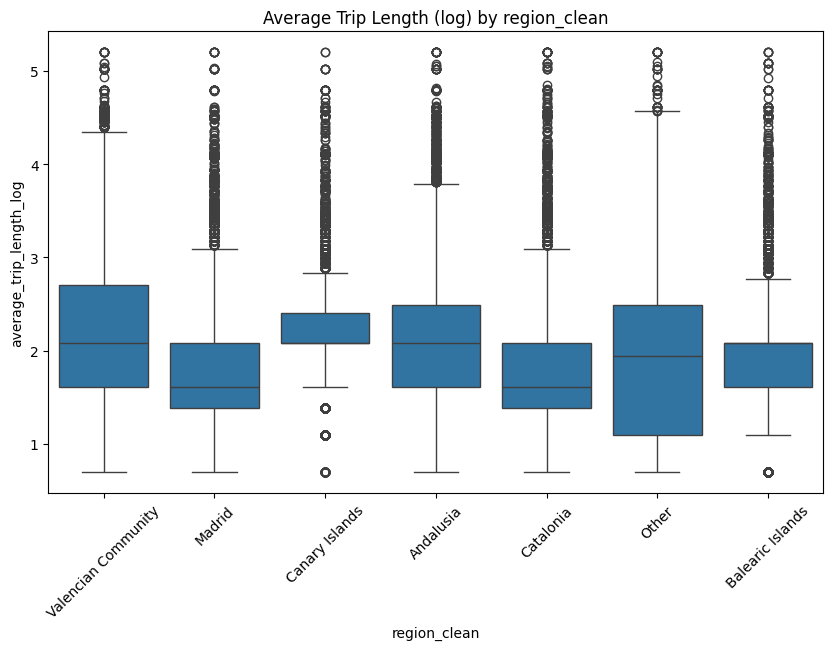

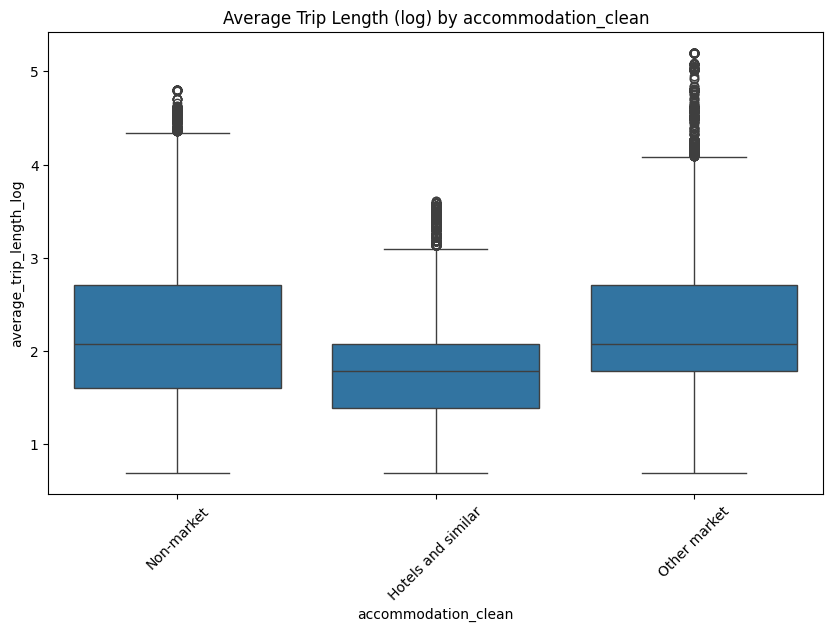

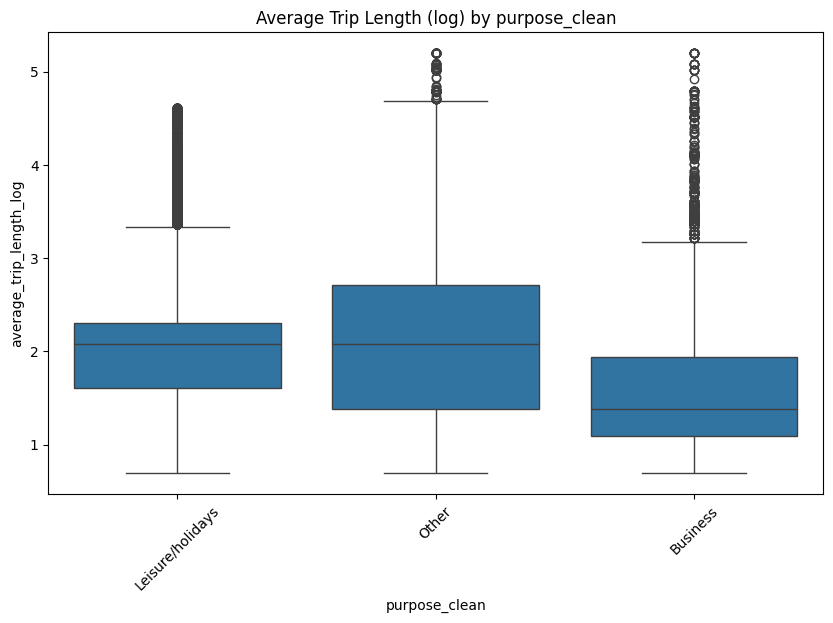

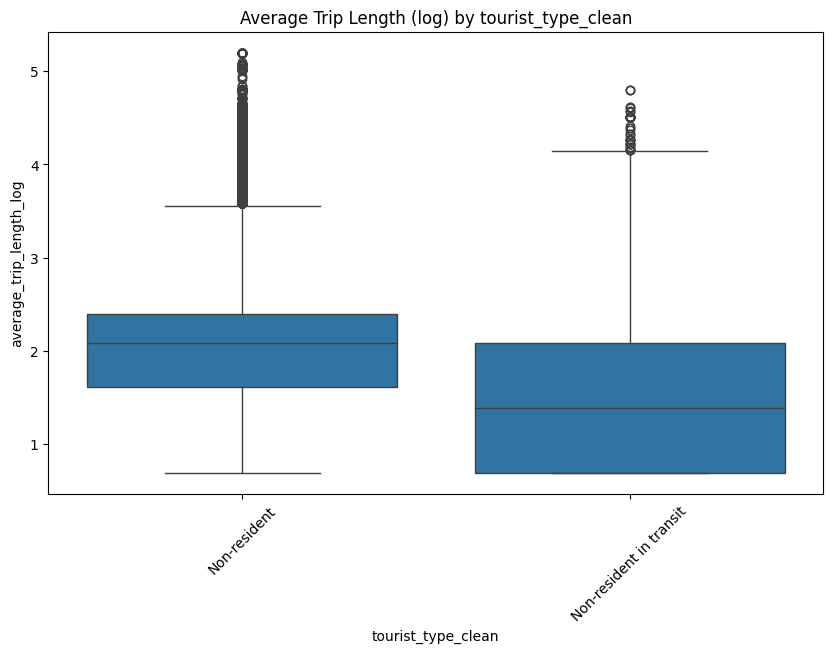

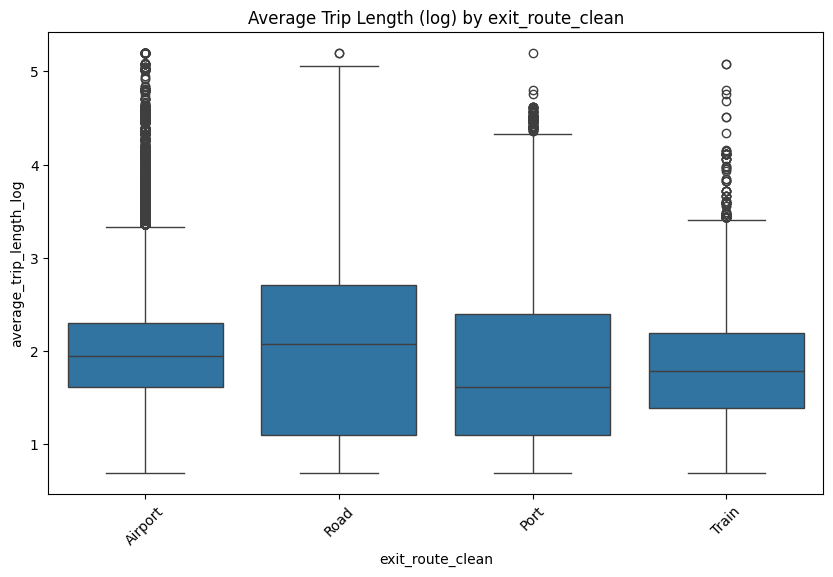

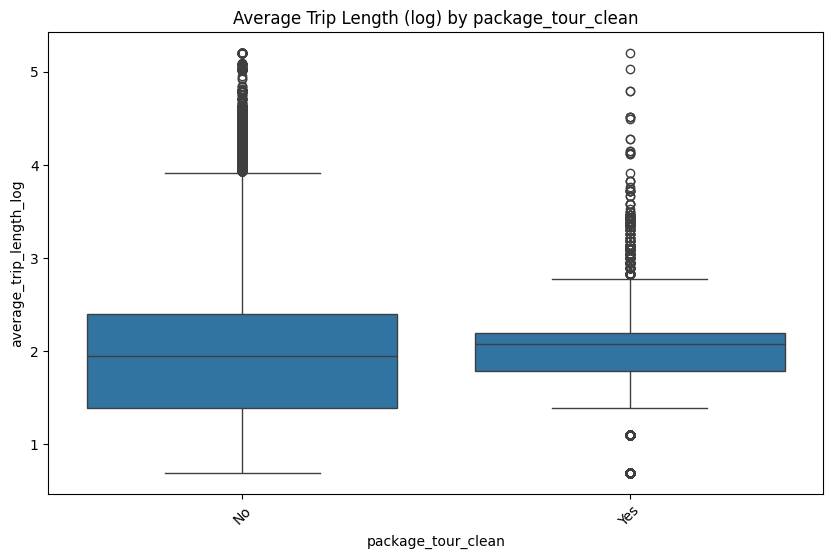

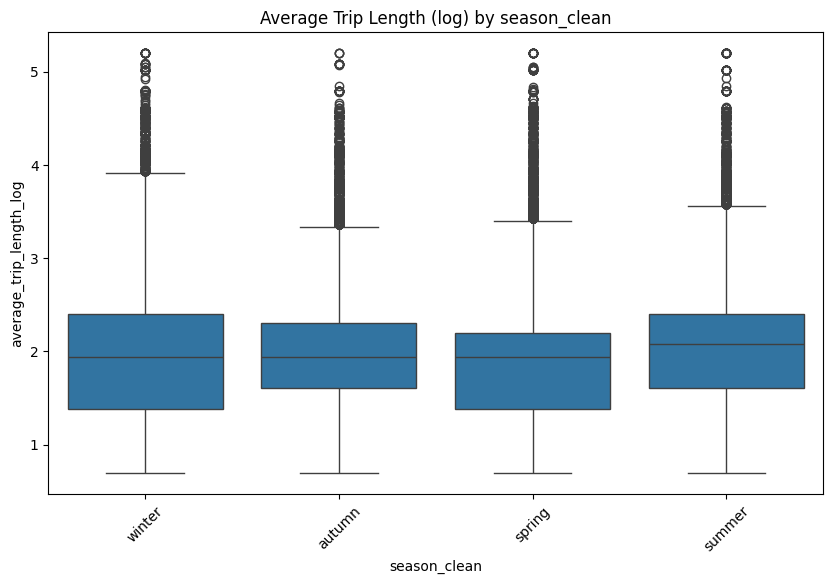

In [290]:
import seaborn as sns
import matplotlib.pyplot as plt

cat_vars = ["country_clean", "region_clean", "accommodation_clean", "purpose_clean",
            "tourist_type_clean", "exit_route_clean", "package_tour_clean", "season_clean"]

for col in cat_vars:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_clean, x=col, y="average_trip_length")
    plt.xticks(rotation=45)
    plt.title(f"Average Trip Length by {col}")
    plt.show()

for col in cat_vars:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_clean, x=col, y="average_trip_length_log")
    plt.xticks(rotation=45)
    plt.title(f"Average Trip Length (log) by {col}")
    plt.show()